## TFM

### DATASETS

In [ ]:
# [datasets]  https://data.mendeley.com/datasets/jxwvdwhpc2/1


## EDA DEL DATASETS

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## MODELOS CNN

In [3]:
import os
import random
import torch

# ==============================
#  Configuración
# ==============================
base_path = "/content/drive/My Drive/Colab Notebooks/clasificacion multiclase"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", device)

# ==============================
# Crear lista de imágenes y etiquetas
# ==============================
image_paths = []
labels = []
clases = set()

for carpeta_grupo in os.listdir(base_path):
    ruta_grupo = os.path.join(base_path, carpeta_grupo)
    if not os.path.isdir(ruta_grupo):
        continue
    for nombre_clase in os.listdir(ruta_grupo):
        ruta_clase = os.path.join(ruta_grupo, nombre_clase)
        if os.path.isdir(ruta_clase):
            clases.add(nombre_clase)

clases = sorted(list(clases))
print("Clases encontradas:", clases)
class_map = {nombre: i for i, nombre in enumerate(clases)}

# Guardar imágenes por clase
imagenes_por_clase = {}
for carpeta_grupo in os.listdir(base_path):
    ruta_grupo = os.path.join(base_path, carpeta_grupo)
    if not os.path.isdir(ruta_grupo):
        continue
    for nombre_clase in os.listdir(ruta_grupo):
        ruta_clase = os.path.join(ruta_grupo, nombre_clase)
        if not os.path.isdir(ruta_clase):
            continue
        imagenes = [
            os.path.join(ruta_clase, img)
            for img in os.listdir(ruta_clase)
            if img.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        if nombre_clase not in imagenes_por_clase:
            imagenes_por_clase[nombre_clase] = []
        imagenes_por_clase[nombre_clase].extend(imagenes)

# Balancear dataset
minimo_imagenes = min(len(lista) for lista in imagenes_por_clase.values())
for clase, lista in imagenes_por_clase.items():
    seleccionadas = random.sample(lista, minimo_imagenes)
    image_paths.extend(seleccionadas)
    labels.extend([class_map[clase]] * minimo_imagenes)

# Verificación final
print(f"\nTotal de imágenes seleccionadas: {len(image_paths)}")
print(f"Total de etiquetas: {len(labels)}")

for clase, idx in class_map.items():
    cantidad = labels.count(idx)
    print(f"Clase '{clase}': {cantidad} imágenes")

Usando dispositivo: cuda
Clases encontradas: ['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']

Total de imágenes seleccionadas: 3552
Total de etiquetas: 3552
Clase 'adenosis': 444 imágenes
Clase 'ductal_carcinoma': 444 imágenes
Clase 'fibroadenoma': 444 imágenes
Clase 'lobular_carcinoma': 444 imágenes
Clase 'mucinous_carcinoma': 444 imágenes
Clase 'papillary_carcinoma': 444 imágenes
Clase 'phyllodes_tumor': 444 imágenes
Clase 'tubular_adenoma': 444 imágenes


### Representación de una imagen por clase

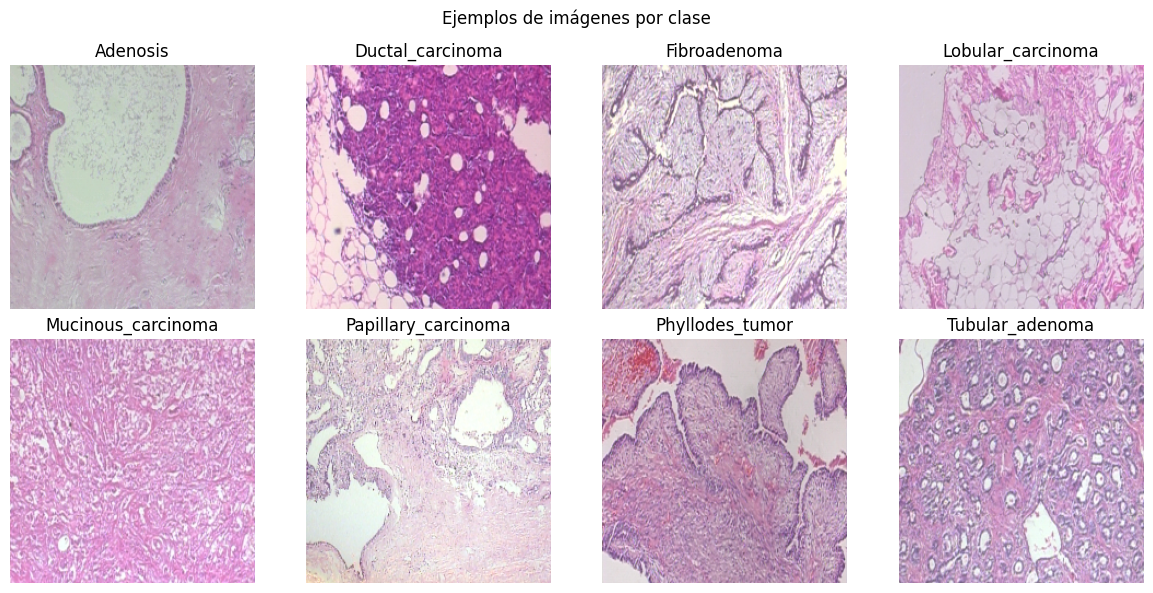

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Número de clases
num_class = len(class_map)
n_cols = 4
n_rows = (num_class + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 3, n_rows * 3))

# Recorrer cada clase por nombre
for idx, class_name in enumerate(class_map.keys()):
    class_path = None
    for group in os.listdir(base_path):
        group_path = os.path.join(base_path, group)
        potential_path = os.path.join(group_path, class_name)
        if os.path.isdir(potential_path):
            class_path = potential_path
            break

    if class_path is None:
        print(f"No se encontró carpeta para clase {class_name}")
        continue

    # Listar imágenes en esa carpeta
    images = [
        img for img in os.listdir(class_path)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    if not images:
        print(f"No hay imágenes en: {class_path}")
        continue

    # Imagen aleatoria
    imagen_random = random.choice(images)
    imagen_path = os.path.join(class_path, imagen_random)
    # print(imagen_path)
    imagen = Image.open(imagen_path)

    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(imagen)
    plt.title(class_name.capitalize())
    plt.axis('off')

plt.suptitle("Ejemplos de imágenes por clase")
plt.tight_layout()
plt.show()


In [4]:
import os
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ==============================
# Codificar etiquetas y split train/test
# ==============================
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)
num_classes = len(le.classes_)
print(f"Número de clases: {num_classes}")

# ==============================
# Transformaciones
# ==============================
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Cargar y transformar imágenes para train
train_images = []
for path in tqdm(train_image_paths):
    img = Image.open(path).convert("RGB")
    img = train_transform(img)
    train_images.append(img)

# Cargar y transformar imágenes para test
test_images = []
for path in tqdm(test_image_paths):
    img = Image.open(path).convert("RGB")
    img = test_transform(img)
    test_images.append(img)


Número de clases: 8


100%|██████████| 711/711 [08:19<00:00,  1.42it/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", device)

# Convertir listas a tensores
X_train_tensor = torch.stack(train_images)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)

X_test_tensor = torch.stack(test_images)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Usando dispositivo: cuda


## MODELO ResNet50

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

# ================================
# Modelo ResNet50 (sin fine-tuning)
# ================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
# Congelar todas las capas excepto la final
for name, param in model.named_parameters():
    if "fc" not in name:  # dejar que se entrene solo la capa final
        param.requires_grad = False

# Reemplazar la capa final (sí se entrena)
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa entrenable): {model.fc}")
model = model.to(device)

#  ==============================================================================
# Función de pérdida y optimizador
#  ==============================================================================
criterion = nn.CrossEntropyLoss()
# 👇 Solo se optimiza la capa final
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

#  ==============================================================================
# Early Stopping
#  ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ================================
# Entrenamiento + Evaluación
# ================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================== Early stopping ============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# ================================
# Restaurar mejores pesos
# ================================
model.load_state_dict(best_model_wts)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


Modelo modificado (última capa entrenable): Linear(in_features=2048, out_features=8, bias=True)


Epoch 1: Train Loss=2.0465, Test Loss=1.9976, Test Acc=0.2616


Epoch 2: Train Loss=1.9438, Test Loss=1.9203, Test Acc=0.3615


Epoch 3: Train Loss=1.8625, Test Loss=1.8497, Test Acc=0.4121


Epoch 4: Train Loss=1.7817, Test Loss=1.7835, Test Acc=0.4459


Epoch 5: Train Loss=1.7220, Test Loss=1.7306, Test Acc=0.4655


Epoch 6: Train Loss=1.6647, Test Loss=1.6863, Test Acc=0.4740


Epoch 7: Train Loss=1.6177, Test Loss=1.6577, Test Acc=0.4824


Epoch 8: Train Loss=1.5654, Test Loss=1.6126, Test Acc=0.5007


Epoch 9: Train Loss=1.5335, Test Loss=1.5761, Test Acc=0.4866


Epoch 10: Train Loss=1.4935, Test Loss=1.5500, Test Acc=0.5232


Epoch 11: Train Loss=1.4630, Test Loss=1.5207, Test Acc=0.5345


Epoch 12: Train Loss=1.4291, Test Loss=1.4984, Test Acc=0.5359


Epoch 13: Train Loss=1.4092, Test Loss=1.4625, Test Acc=0.5387


Epoch 14: Train Loss=1.3797, Test Loss=1.4549, Test Acc=0.5345


Epoch 15: Train Loss=1.3500, Test Loss=1.4243, Test Acc=0.5527


Epoch 16: Train Loss=1.3297, Test Loss=1.4175, Test Acc=0.5373


Epoch 17: Train Loss=1.3110, Test Loss=1.3948, Test Acc=0.5612


Epoch 18: Train Loss=1.2950, Test Loss=1.3913, Test Acc=0.5556


Epoch 19: Train Loss=1.2725, Test Loss=1.3786, Test Acc=0.5584


Epoch 20: Train Loss=1.2509, Test Loss=1.3639, Test Acc=0.5584


Epoch 21: Train Loss=1.2413, Test Loss=1.3418, Test Acc=0.5626


Epoch 22: Train Loss=1.2229, Test Loss=1.3370, Test Acc=0.5795


Epoch 23: Train Loss=1.2031, Test Loss=1.3303, Test Acc=0.5752


Epoch 24: Train Loss=1.1861, Test Loss=1.2896, Test Acc=0.5626


Epoch 25: Train Loss=1.1756, Test Loss=1.2900, Test Acc=0.5851


Epoch 26: Train Loss=1.1573, Test Loss=1.2807, Test Acc=0.5795


Epoch 27: Train Loss=1.1416, Test Loss=1.2793, Test Acc=0.5724


Epoch 28: Train Loss=1.1356, Test Loss=1.2769, Test Acc=0.5893


Epoch 29: Train Loss=1.1209, Test Loss=1.2571, Test Acc=0.5879


Epoch 30: Train Loss=1.1005, Test Loss=1.2488, Test Acc=0.6048


Epoch 31: Train Loss=1.0880, Test Loss=1.2479, Test Acc=0.5851


Epoch 32: Train Loss=1.0861, Test Loss=1.2453, Test Acc=0.5921


Epoch 33: Train Loss=1.0735, Test Loss=1.2304, Test Acc=0.5949


Epoch 34: Train Loss=1.0605, Test Loss=1.2189, Test Acc=0.5907


Epoch 35: Train Loss=1.0552, Test Loss=1.2032, Test Acc=0.5963


Epoch 36: Train Loss=1.0424, Test Loss=1.2030, Test Acc=0.5977


Epoch 37: Train Loss=1.0313, Test Loss=1.2001, Test Acc=0.6048


Epoch 38: Train Loss=1.0278, Test Loss=1.1902, Test Acc=0.6174


Epoch 39: Train Loss=1.0158, Test Loss=1.1923, Test Acc=0.6006


Epoch 40: Train Loss=1.0076, Test Loss=1.1714, Test Acc=0.6231


Epoch 41: Train Loss=0.9956, Test Loss=1.1732, Test Acc=0.6062


Epoch 42: Train Loss=0.9810, Test Loss=1.1729, Test Acc=0.6020


Epoch 43: Train Loss=0.9843, Test Loss=1.1531, Test Acc=0.6160


Epoch 44: Train Loss=0.9731, Test Loss=1.1509, Test Acc=0.6146


Epoch 45: Train Loss=0.9614, Test Loss=1.1434, Test Acc=0.6188


Epoch 46: Train Loss=0.9614, Test Loss=1.1399, Test Acc=0.6343


Epoch 47: Train Loss=0.9378, Test Loss=1.1519, Test Acc=0.6203


Epoch 48: Train Loss=0.9389, Test Loss=1.1351, Test Acc=0.6273


Epoch 49: Train Loss=0.9228, Test Loss=1.1331, Test Acc=0.6357


Epoch 50: Train Loss=0.9116, Test Loss=1.1262, Test Acc=0.6287


<All keys matched successfully>

In [7]:
# Prueba 1
true_labels_resnet50_0 = true_labels_list
pred_labels_resnet50_0 = pred_labels_list
prob_resnet50_0 = prob_list

In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo modificado (última capa): Linear(in_features=2048, out_features=8, bias=True)


Epoch 1: Train Loss=1.7319, Test Loss=1.1079, Test Acc=0.6273


Epoch 2: Train Loss=0.8176, Test Loss=0.7194, Test Acc=0.7595


Epoch 3: Train Loss=0.3373, Test Loss=0.6031, Test Acc=0.7932


Epoch 4: Train Loss=0.1425, Test Loss=0.5398, Test Acc=0.8101


Epoch 5: Train Loss=0.0926, Test Loss=0.5544, Test Acc=0.8158


Epoch 6: Train Loss=0.0616, Test Loss=0.6333, Test Acc=0.7862


Epoch 7: Train Loss=0.0544, Test Loss=0.6113, Test Acc=0.8059
🛑 Early stopping activado en la época 7


<All keys matched successfully>

In [ ]:
# Prueba 1
true_labels_resnet50_1 = true_labels_list
pred_labels_resnet50_1 = pred_labels_list
prob_resnet50_1 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_resnet50_1 = accuracy_score(true_labels_resnet50_1, pred_labels_resnet50_1)
error_rate_resnet50_1 = 1 - acc_resnet50_1
print(f"Accuracy total: {acc_resnet50_1:.4f}, Error rate: {error_rate_resnet50_1:.4f}\n")

print(classification_report(
    true_labels_resnet50_1,
    pred_labels_resnet50_1,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8059, Error rate: 0.1941

                     precision    recall  f1-score   support

           adenosis       0.80      0.96      0.87        89
   ductal_carcinoma       0.64      0.73      0.68        88
       fibroadenoma       0.80      0.71      0.75        89
  lobular_carcinoma       0.74      0.76      0.75        89
 mucinous_carcinoma       0.84      0.79      0.81        89
papillary_carcinoma       0.89      0.83      0.86        89
    phyllodes_tumor       0.86      0.80      0.83        89
    tubular_adenoma       0.92      0.88      0.90        89

           accuracy                           0.81       711
          macro avg       0.81      0.81      0.81       711
       weighted avg       0.81      0.81      0.81       711



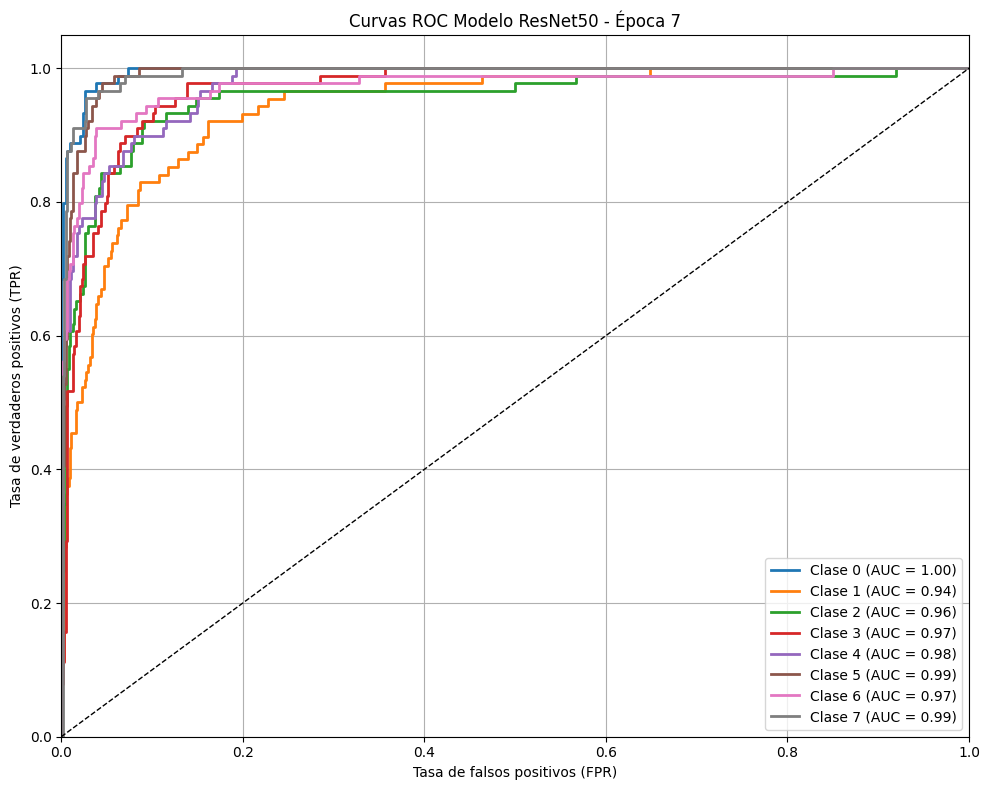

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_resnet50_1, classes=list(range(num_classes)))
y_score = np.array(prob_resnet50_1)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo ResNet50 - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


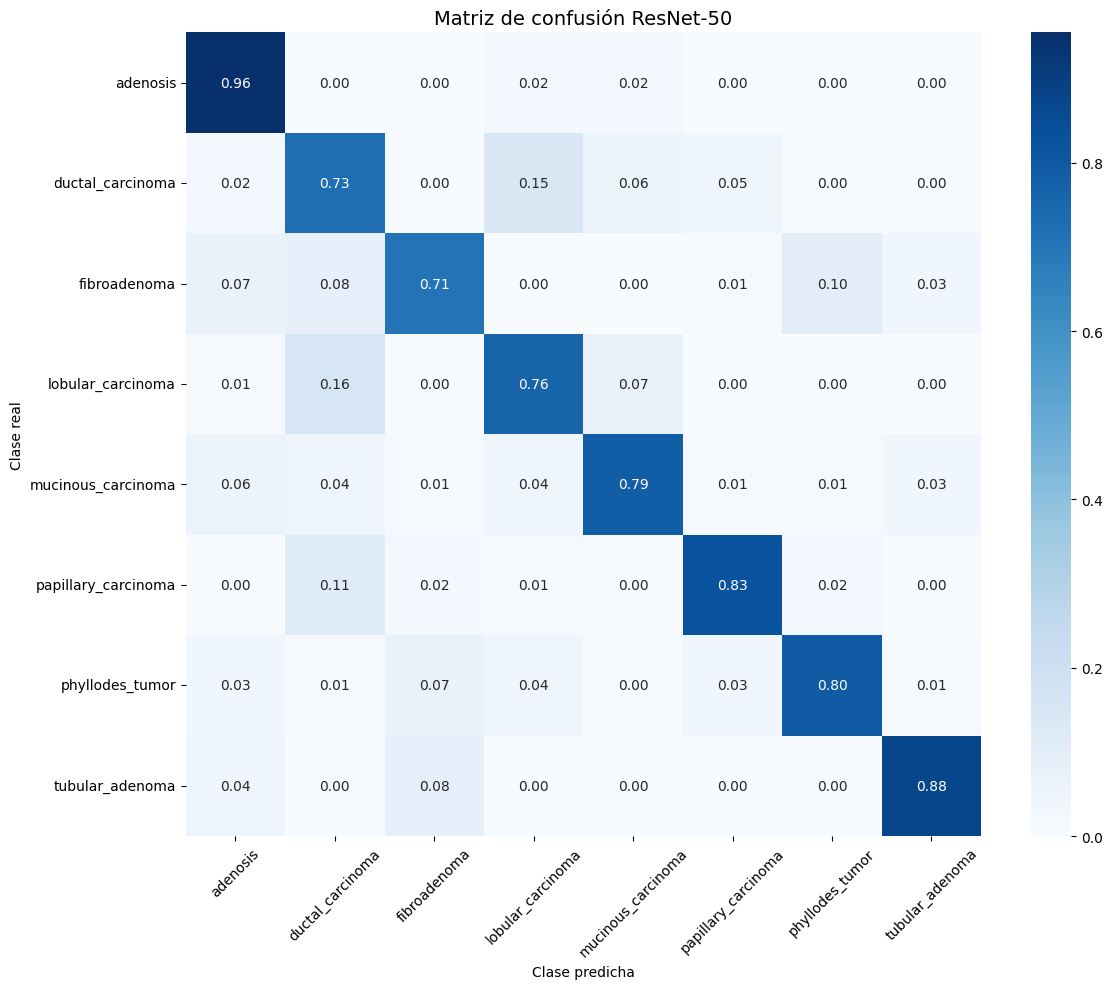

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_resnet50_1, pred_labels_resnet50_1)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión ResNet-50", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo modificado (última capa): Linear(in_features=2048, out_features=8, bias=True)


Epoch 1: Train Loss=1.7417, Test Loss=1.1588, Test Acc=0.5992


Epoch 2: Train Loss=0.8278, Test Loss=0.6837, Test Acc=0.7750


Epoch 3: Train Loss=0.3635, Test Loss=0.5772, Test Acc=0.7834


Epoch 4: Train Loss=0.1648, Test Loss=0.5835, Test Acc=0.7876


Epoch 5: Train Loss=0.0862, Test Loss=0.6504, Test Acc=0.7890


Epoch 6: Train Loss=0.0790, Test Loss=0.5806, Test Acc=0.8059
🛑 Early stopping activado en la época 6


<All keys matched successfully>

In [ ]:
# Prueba 2
true_labels_resnet50_2 = true_labels_list
pred_labels_resnet50_2 = pred_labels_list
prob_resnet50_2 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_resnet50_2 = accuracy_score(true_labels_resnet50_2, pred_labels_resnet50_2)
error_rate_resnet50_2 = 1 - acc_resnet50_2
print(f"Accuracy total: {acc_resnet50_2:.4f}, Error rate: {error_rate_resnet50_2:.4f}\n")

print(classification_report(
    true_labels_resnet50_2,
    pred_labels_resnet50_2,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8059, Error rate: 0.1941

                     precision    recall  f1-score   support

           adenosis       0.88      0.89      0.88        89
   ductal_carcinoma       0.74      0.65      0.69        88
       fibroadenoma       0.74      0.79      0.77        89
  lobular_carcinoma       0.80      0.82      0.81        89
 mucinous_carcinoma       0.77      0.81      0.79        89
papillary_carcinoma       0.90      0.79      0.84        89
    phyllodes_tumor       0.78      0.81      0.80        89
    tubular_adenoma       0.84      0.90      0.87        89

           accuracy                           0.81       711
          macro avg       0.81      0.81      0.81       711
       weighted avg       0.81      0.81      0.81       711



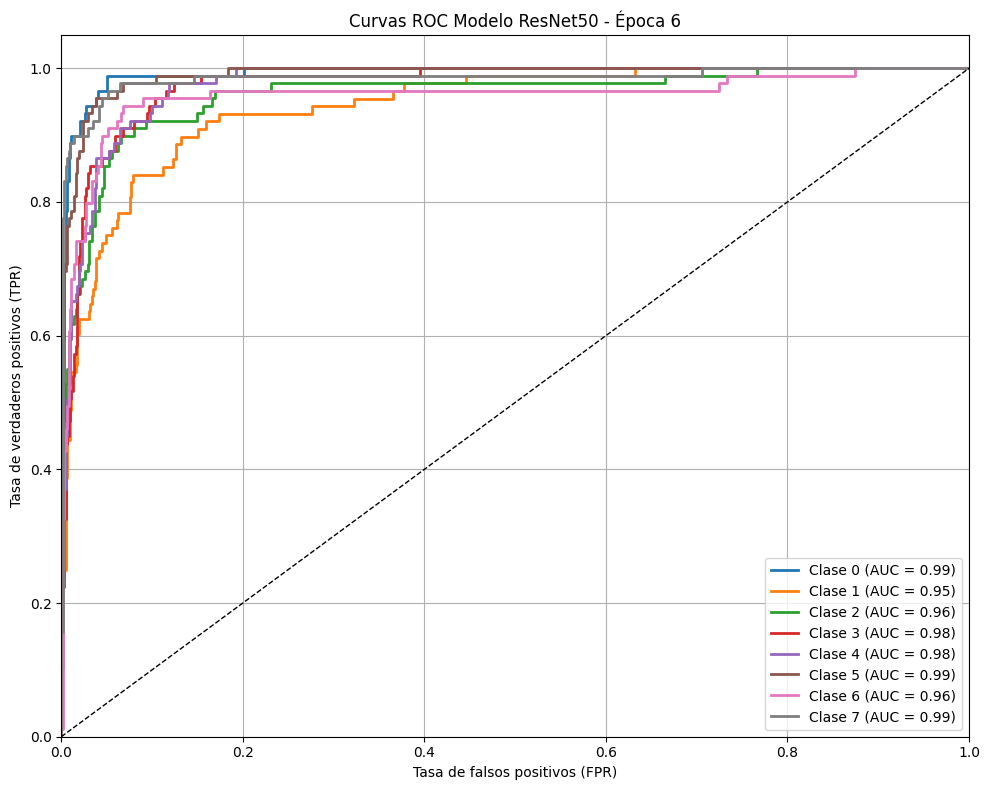

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_resnet50_2, classes=list(range(num_classes)))
y_score = np.array(prob_resnet50_2)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo ResNet50 - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


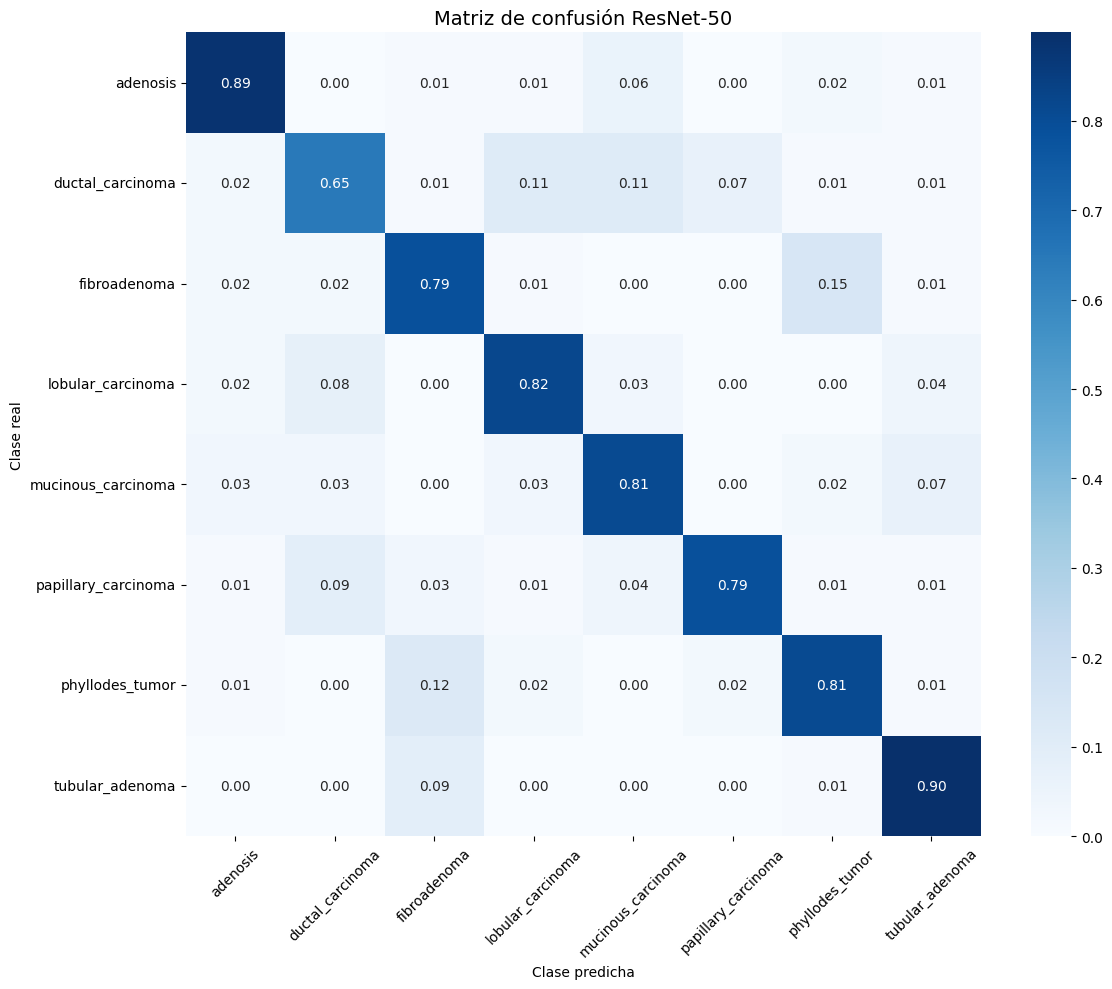

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_resnet50_2, pred_labels_resnet50_2)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión ResNet-50", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False


# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False


# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Test]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)

    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================ Early Stopping ==============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Linear(in_features=2048, out_features=8, bias=True)


Epoch 1: Train Loss=1.7548, Test Loss=1.2683, Test Acc=0.5598


Epoch 2: Train Loss=0.9569, Test Loss=0.6940, Test Acc=0.7356


Epoch 3: Train Loss=0.5970, Test Loss=0.4835, Test Acc=0.8228


Epoch 4: Train Loss=0.4286, Test Loss=0.4435, Test Acc=0.8509


Epoch 5: Train Loss=0.2960, Test Loss=0.4034, Test Acc=0.8720


Epoch 6: Train Loss=0.2524, Test Loss=0.3460, Test Acc=0.8903


Epoch 7: Train Loss=0.1994, Test Loss=0.3111, Test Acc=0.8987


Epoch 8: Train Loss=0.1539, Test Loss=0.3203, Test Acc=0.8987


Epoch 9: Train Loss=0.1231, Test Loss=0.2781, Test Acc=0.9283


Epoch 10: Train Loss=0.1173, Test Loss=0.2759, Test Acc=0.9198


Epoch 11: Train Loss=0.1003, Test Loss=0.3523, Test Acc=0.9072


Epoch 12: Train Loss=0.0832, Test Loss=0.2989, Test Acc=0.9156


Epoch 13: Train Loss=0.0863, Test Loss=0.3234, Test Acc=0.9142
🛑 Early stopping en epoch 13


<All keys matched successfully>

In [ ]:
# Prueba 3
true_labels_resnet50_3 = true_labels_list
pred_labels_resnet50_3 = pred_labels_list
prob_resnet50_3 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_resnet50_3 = accuracy_score(true_labels_resnet50_3, pred_labels_resnet50_3)
error_rate_resnet50_3 = 1 - acc_resnet50_3
print(f"Accuracy total: {acc_resnet50_3:.4f}, Error rate: {error_rate_resnet50_3:.4f}")

print(classification_report(
    true_labels_resnet50_3,
    pred_labels_resnet50_3,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))


Accuracy total: 0.9142, Error rate: 0.0858
                     precision    recall  f1-score   support

           adenosis       0.97      1.00      0.98        89
   ductal_carcinoma       0.92      0.78      0.85        88
       fibroadenoma       0.91      0.83      0.87        89
  lobular_carcinoma       0.85      0.91      0.88        89
 mucinous_carcinoma       0.91      0.94      0.93        89
papillary_carcinoma       0.95      0.93      0.94        89
    phyllodes_tumor       0.85      0.92      0.88        89
    tubular_adenoma       0.96      0.99      0.97        89

           accuracy                           0.91       711
          macro avg       0.92      0.91      0.91       711
       weighted avg       0.92      0.91      0.91       711



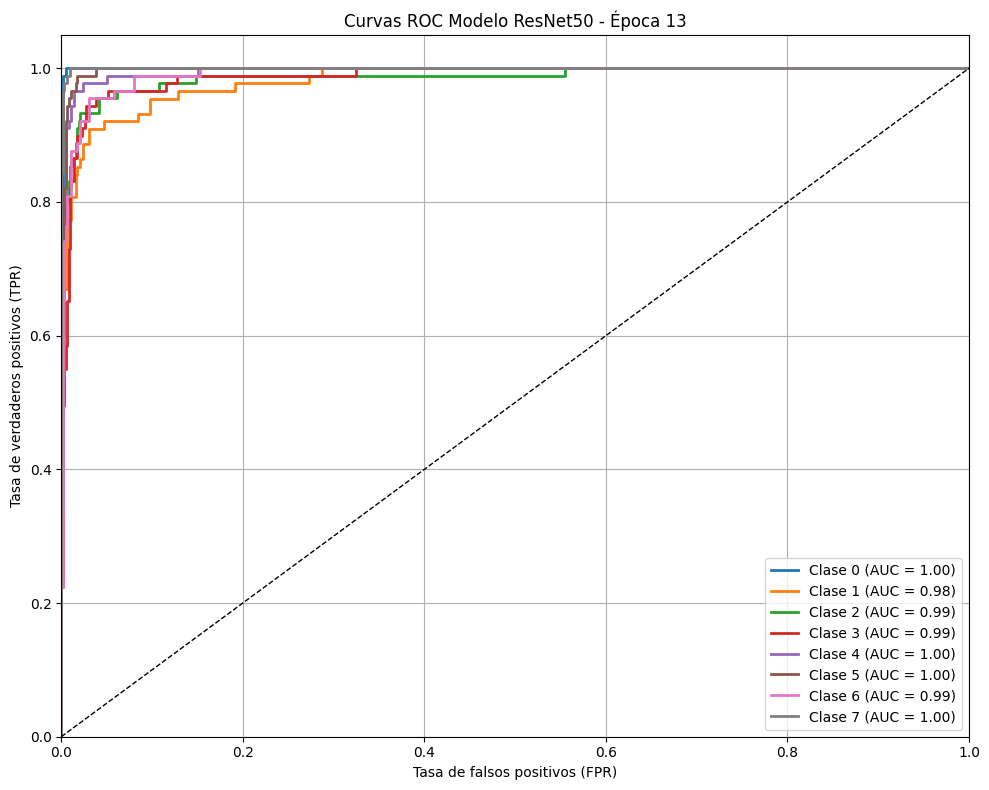

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_resnet50_3, classes=list(range(num_classes)))
y_score = np.array(prob_resnet50_3)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo ResNet50 - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


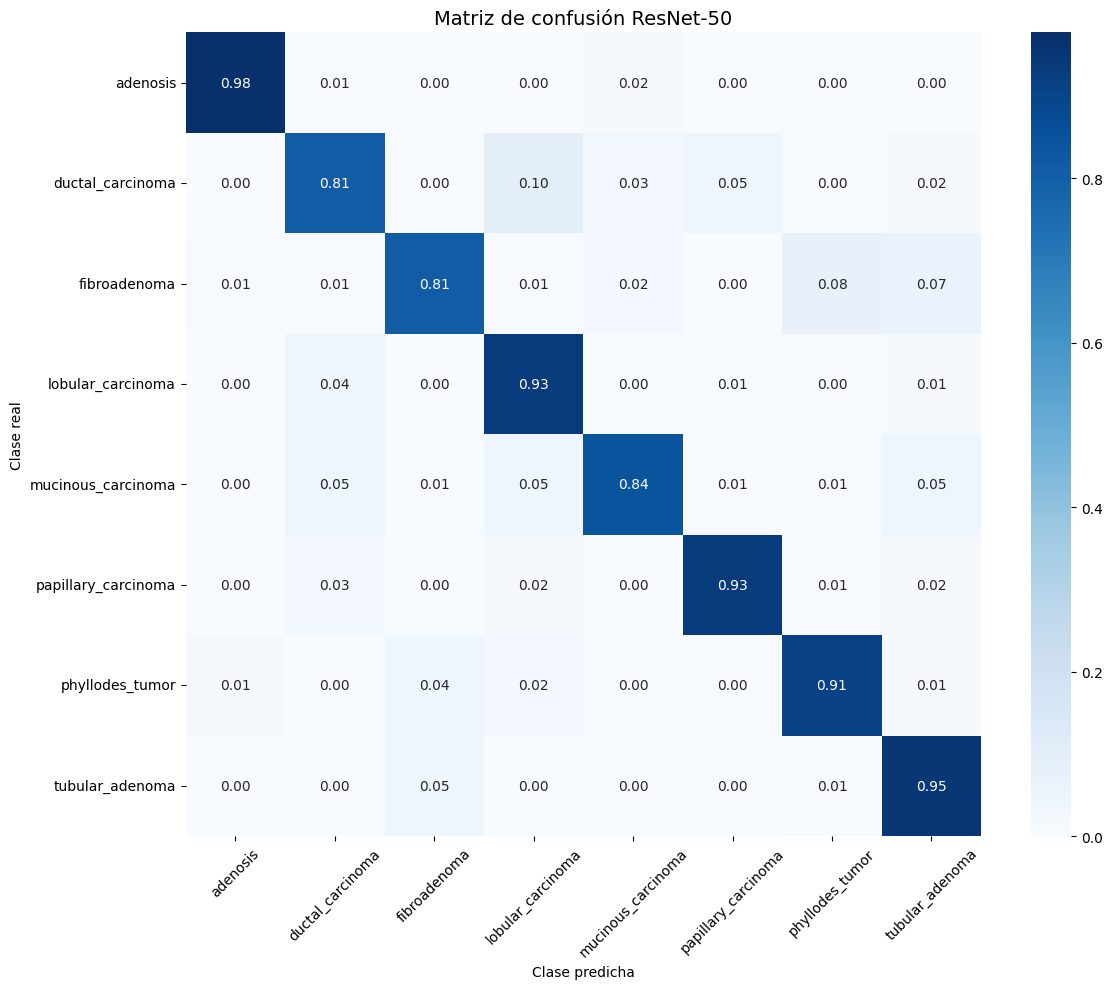

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_resnet50_3, pred_labels_resnet50_3)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión ResNet-50", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo ResNet50 preentrenado
# ==================================
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la capa fully connected (fc)
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # ============================== Evaluación  ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Test]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)


    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Linear(in_features=2048, out_features=8, bias=True)


Epoch 1: Train Loss=1.7164, Test Loss=1.2516, Test Acc=0.5823


Epoch 2: Train Loss=0.9159, Test Loss=0.7152, Test Acc=0.7567


Epoch 3: Train Loss=0.5923, Test Loss=0.5357, Test Acc=0.8143


Epoch 4: Train Loss=0.4199, Test Loss=0.3927, Test Acc=0.8551


Epoch 5: Train Loss=0.3168, Test Loss=0.3778, Test Acc=0.8790


Epoch 6: Train Loss=0.2536, Test Loss=0.3330, Test Acc=0.8847


Epoch 7: Train Loss=0.1945, Test Loss=0.4071, Test Acc=0.8748


Epoch 8: Train Loss=0.1441, Test Loss=0.3739, Test Acc=0.8734


Epoch 9: Train Loss=0.1607, Test Loss=0.3356, Test Acc=0.9044
🛑 Early stopping en epoch 9


<All keys matched successfully>

In [ ]:
# Prueba 4
true_labels_resnet50_4 = true_labels_list
pred_labels_resnet50_4 = pred_labels_list
prob_resnet50_4 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_resnet50_4 = accuracy_score(true_labels_resnet50_4, pred_labels_resnet50_4)
error_rate_resnet50_4 = 1 - acc_resnet50_4
print(f"Accuracy total: {acc_resnet50_4:.4f}, Error rate: {error_rate_resnet50_4:.4f}")

print(classification_report(
    true_labels_resnet50_4,
    pred_labels_resnet50_4,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))


Accuracy total: 0.9044, Error rate: 0.0956
                     precision    recall  f1-score   support

           adenosis       0.96      0.97      0.96        89
   ductal_carcinoma       0.80      0.86      0.83        88
       fibroadenoma       0.84      0.93      0.88        89
  lobular_carcinoma       0.91      0.75      0.82        89
 mucinous_carcinoma       0.91      0.91      0.91        89
papillary_carcinoma       0.95      0.97      0.96        89
    phyllodes_tumor       0.96      0.87      0.91        89
    tubular_adenoma       0.94      0.98      0.96        89

           accuracy                           0.90       711
          macro avg       0.91      0.90      0.90       711
       weighted avg       0.91      0.90      0.90       711



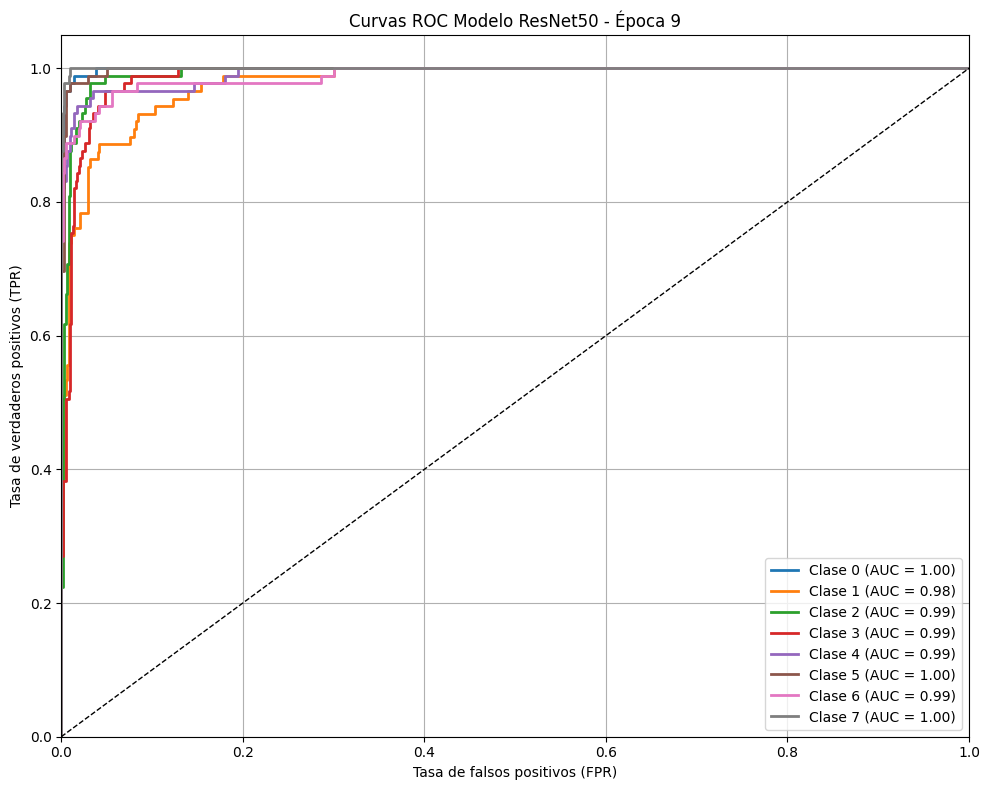

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_resnet50_4, classes=list(range(num_classes)))
y_score = np.array(prob_resnet50_4)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo ResNet50 - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


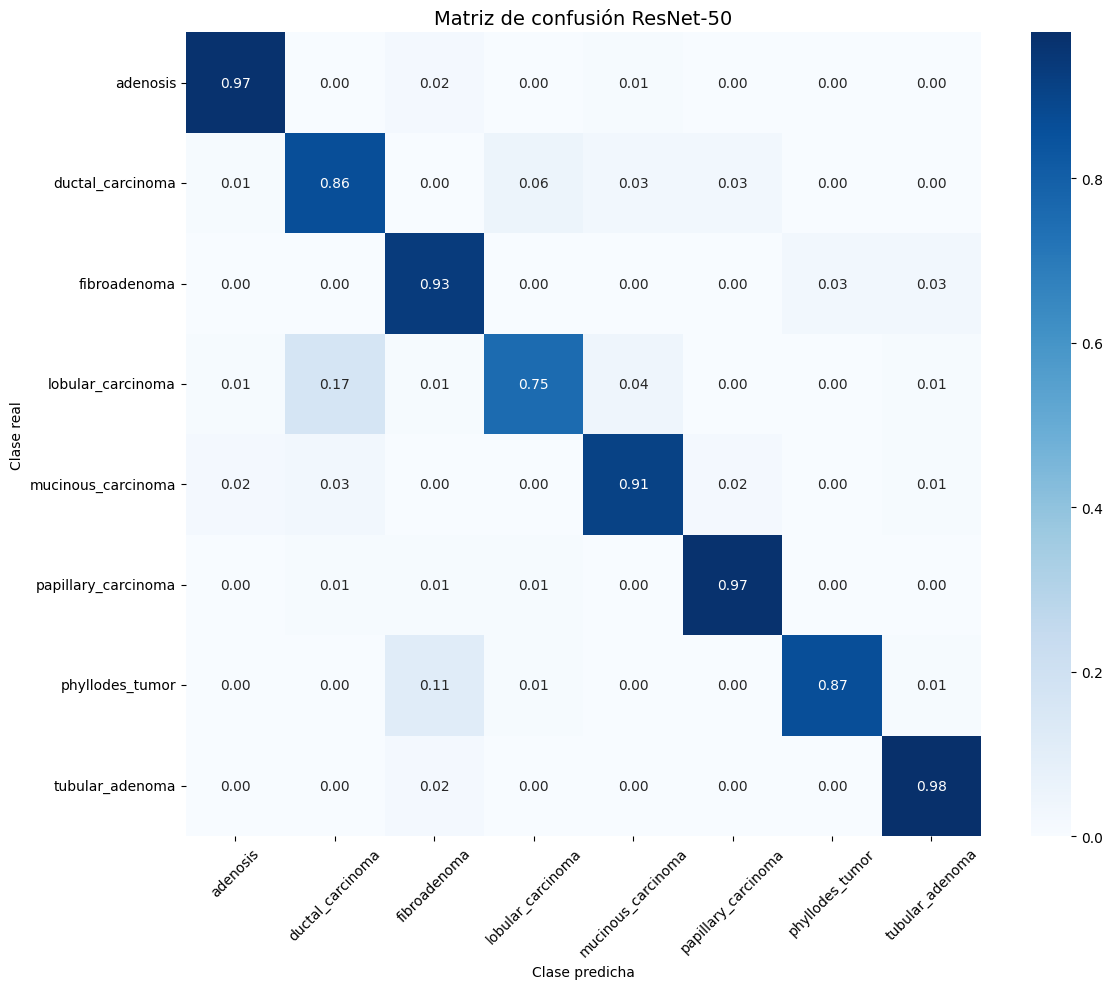

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_resnet50_4, pred_labels_resnet50_4)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión ResNet-50", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## MODEL DesNet

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

# =================================
# Modelo DenseNet121 preentrenado
# =================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 202MB/s]


Modelo modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.4254, Test Loss=0.8792, Test Acc=0.7089


Epoch 2: Train Loss=0.6434, Test Loss=0.5999, Test Acc=0.8003


Epoch 3: Train Loss=0.3329, Test Loss=0.4976, Test Acc=0.8312


Epoch 4: Train Loss=0.1599, Test Loss=0.5066, Test Acc=0.8242


Epoch 5: Train Loss=0.0889, Test Loss=0.4929, Test Acc=0.8368


Epoch 6: Train Loss=0.0660, Test Loss=0.5328, Test Acc=0.8256


Epoch 7: Train Loss=0.0447, Test Loss=0.5656, Test Acc=0.8340


Epoch 8: Train Loss=0.0453, Test Loss=0.5647, Test Acc=0.8368
🛑 Early stopping activado en la época 8


<All keys matched successfully>

In [ ]:
# Prueba 1
true_labels_densenet121_1 = true_labels_list
pred_labels_densenet121_1 = pred_labels_list
prob_densenet121_1 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_densenet121_1 = accuracy_score(true_labels_densenet121_1, pred_labels_densenet121_1)
error_rate_densenet121_1 = 1 - acc_densenet121_1
print(f"Accuracy total: {acc_densenet121_1:.4f}, Error rate: {error_rate_densenet121_1:.4f}\n")

print(classification_report(
    true_labels_densenet121_1,
    pred_labels_densenet121_1,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8368, Error rate: 0.1632

                     precision    recall  f1-score   support

           adenosis       0.92      0.96      0.94        89
   ductal_carcinoma       0.79      0.65      0.71        88
       fibroadenoma       0.80      0.81      0.80        89
  lobular_carcinoma       0.76      0.74      0.75        89
 mucinous_carcinoma       0.76      0.89      0.82        89
papillary_carcinoma       0.92      0.85      0.88        89
    phyllodes_tumor       0.87      0.85      0.86        89
    tubular_adenoma       0.88      0.94      0.91        89

           accuracy                           0.84       711
          macro avg       0.84      0.84      0.84       711
       weighted avg       0.84      0.84      0.84       711



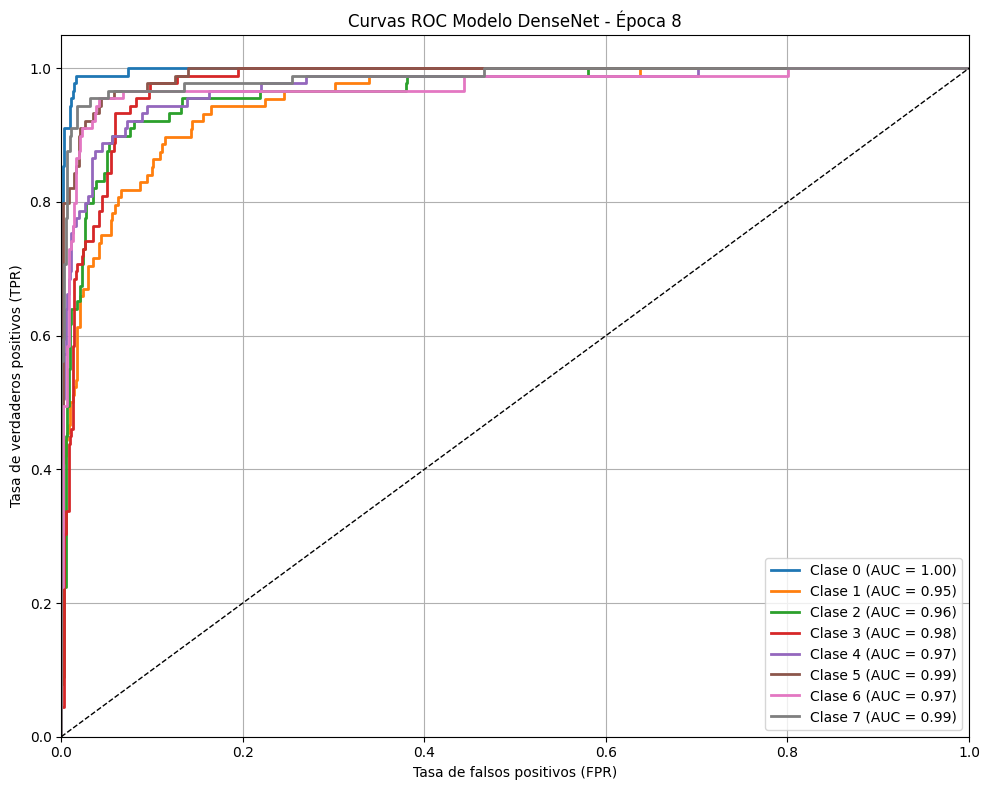

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_densenet121_1, classes=list(range(num_classes)))
y_score = np.array(prob_densenet121_1)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo DenseNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


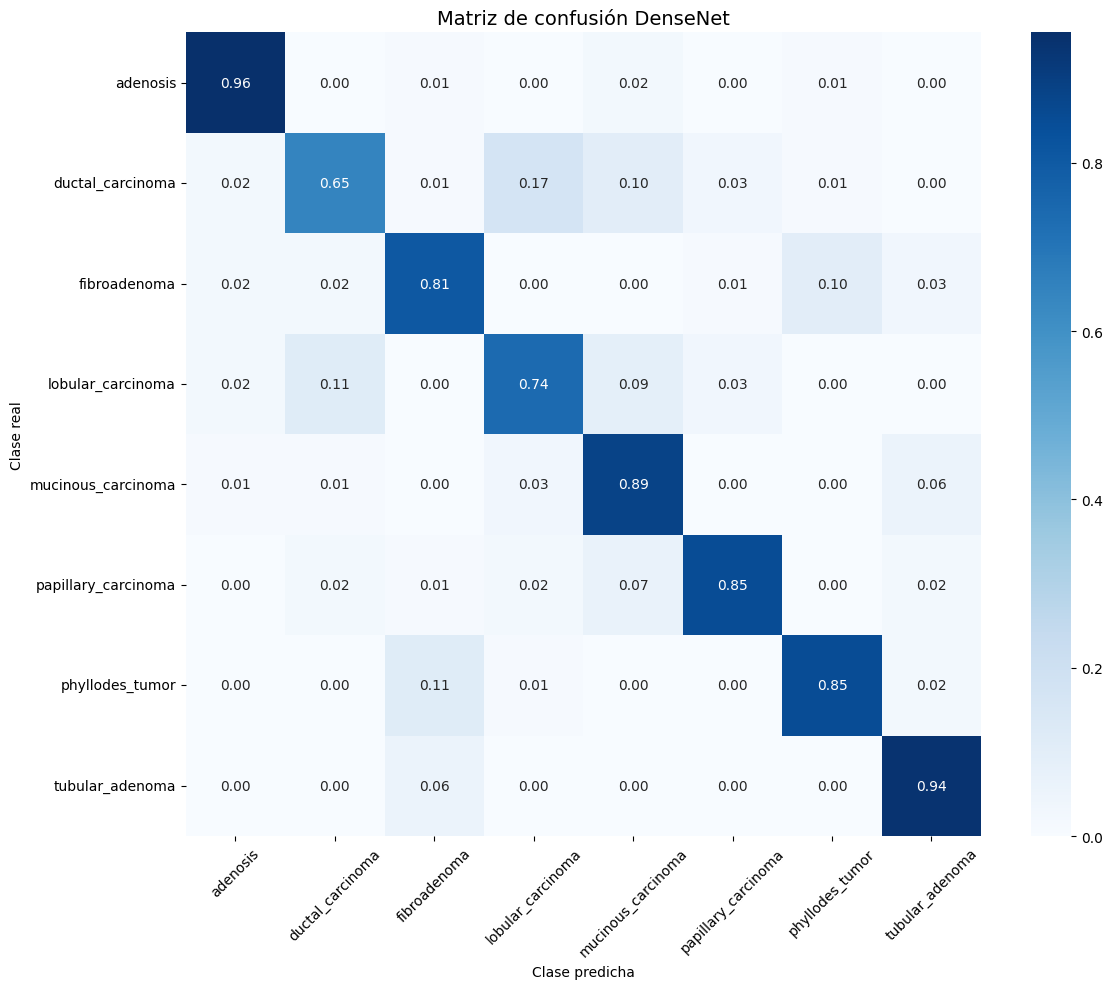

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_densenet121_1, pred_labels_densenet121_1)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión DenseNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

# =================================
# Modelo DenseNet121 preentrenado
# =================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.4350, Test Loss=0.8738, Test Acc=0.7075


Epoch 2: Train Loss=0.6352, Test Loss=0.6302, Test Acc=0.7736


Epoch 3: Train Loss=0.3233, Test Loss=0.5725, Test Acc=0.7961


Epoch 4: Train Loss=0.1642, Test Loss=0.5737, Test Acc=0.8129


Epoch 5: Train Loss=0.0852, Test Loss=0.5805, Test Acc=0.8143


Epoch 6: Train Loss=0.0635, Test Loss=0.5904, Test Acc=0.8368
🛑 Early stopping activado en la época 6


<All keys matched successfully>

In [ ]:
# Prueba 2
true_labels_densenet121_2 = true_labels_list
pred_labels_densenet121_2 = pred_labels_list
prob_densenet121_2 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_densenet121_2 = accuracy_score(true_labels_densenet121_2, pred_labels_densenet121_2)
error_rate_densenet121_2 = 1 - acc_densenet121_2
print(f"Accuracy total: {acc_densenet121_2:.4f}, Error rate: {error_rate_densenet121_2:.4f}\n")

print(classification_report(
    true_labels_densenet121_2,
    pred_labels_densenet121_2,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8368, Error rate: 0.1632

                     precision    recall  f1-score   support

           adenosis       0.93      0.93      0.93        89
   ductal_carcinoma       0.77      0.72      0.74        88
       fibroadenoma       0.71      0.87      0.78        89
  lobular_carcinoma       0.84      0.72      0.78        89
 mucinous_carcinoma       0.75      0.91      0.82        89
papillary_carcinoma       0.95      0.83      0.89        89
    phyllodes_tumor       0.95      0.79      0.86        89
    tubular_adenoma       0.86      0.93      0.90        89

           accuracy                           0.84       711
          macro avg       0.85      0.84      0.84       711
       weighted avg       0.85      0.84      0.84       711



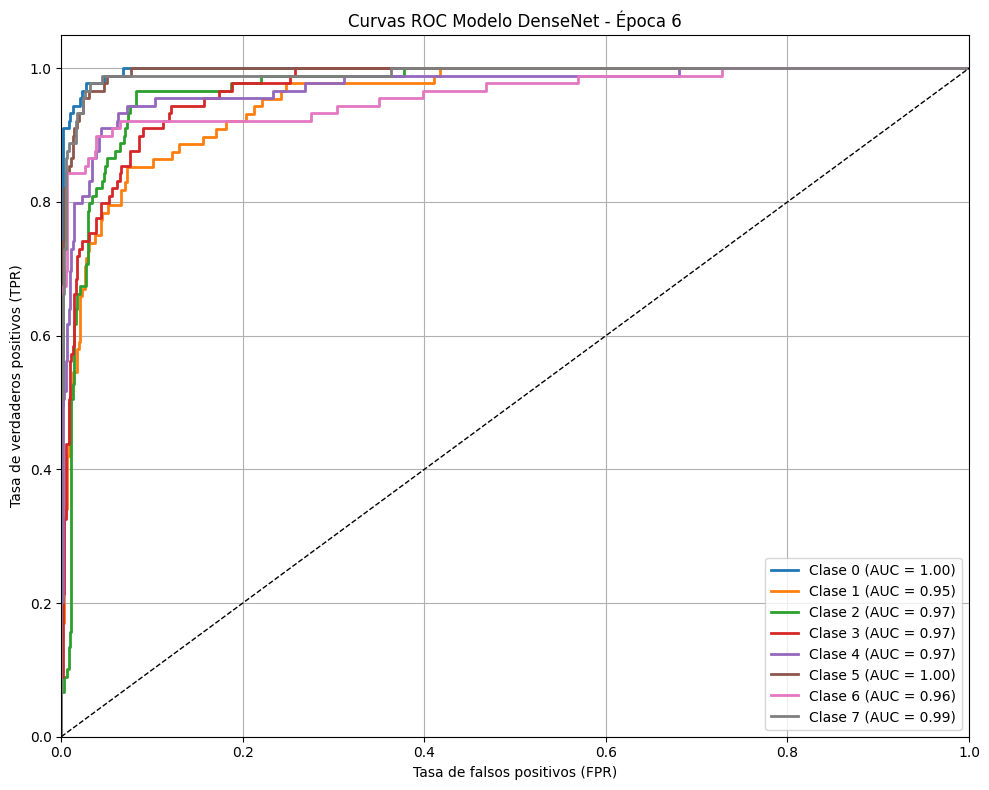

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_densenet121_2, classes=list(range(num_classes)))
y_score = np.array(prob_densenet121_2)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo DenseNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


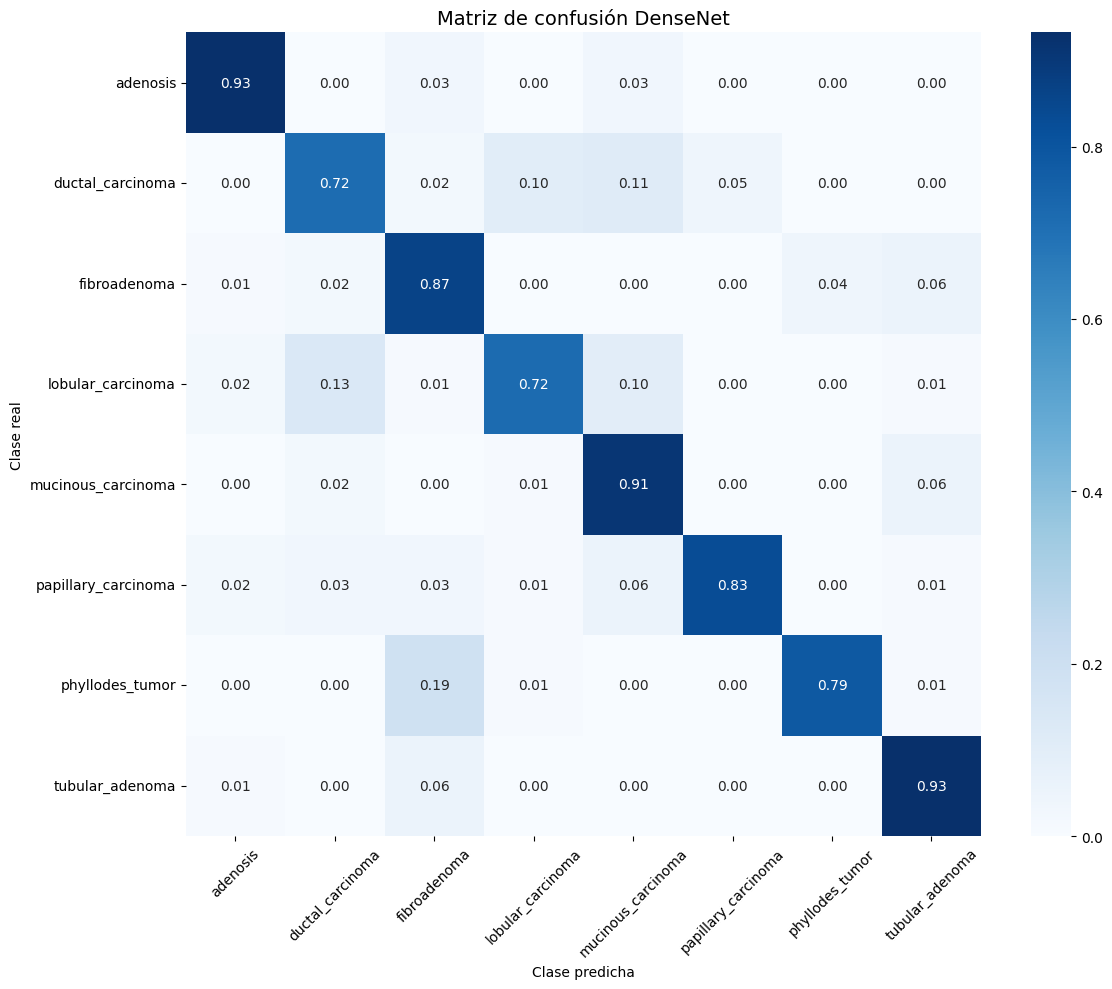

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_densenet121_2, pred_labels_densenet121_2)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión DenseNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

# =================================
# Modelo DenseNet121 preentrenado
# =================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo DenseNet121 preentrenado
# ==================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False


# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Época {epoch+1} [Test]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)

    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\r🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.4213, Test Loss=0.8961, Test Acc=0.7060


Epoch 2: Train Loss=0.7375, Test Loss=0.5963, Test Acc=0.7932


Epoch 3: Train Loss=0.5118, Test Loss=0.5374, Test Acc=0.8256


Epoch 4: Train Loss=0.4066, Test Loss=0.4468, Test Acc=0.8523


Epoch 5: Train Loss=0.3027, Test Loss=0.4010, Test Acc=0.8664


Epoch 6: Train Loss=0.2648, Test Loss=0.4166, Test Acc=0.8650


Epoch 7: Train Loss=0.1877, Test Loss=0.3830, Test Acc=0.8762


Epoch 8: Train Loss=0.1777, Test Loss=0.4395, Test Acc=0.8622


Epoch 9: Train Loss=0.1611, Test Loss=0.3710, Test Acc=0.8748


Epoch 10: Train Loss=0.1217, Test Loss=0.3744, Test Acc=0.8973


Epoch 11: Train Loss=0.1384, Test Loss=0.3227, Test Acc=0.8973


Epoch 12: Train Loss=0.1066, Test Loss=0.3582, Test Acc=0.8987


Epoch 13: Train Loss=0.0854, Test Loss=0.3004, Test Acc=0.9114


Epoch 14: Train Loss=0.0788, Test Loss=0.4057, Test Acc=0.8917


Epoch 15: Train Loss=0.0746, Test Loss=0.4110, Test Acc=0.8762


Epoch 16: Train Loss=0.0800, Test Loss=0.4421, Test Acc=0.8678
🛑 Early stopping en epoch 16


<All keys matched successfully>

In [ ]:
# Prueba 3
true_labels_densenet121_3 = true_labels_list
pred_labels_densenet121_3 = pred_labels_list
prob_densenet121_3 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_densenet121_3 = accuracy_score(true_labels_densenet121_3, pred_labels_densenet121_3)
error_rate_densenet121_3 = 1 - acc_densenet121_3
print(f"Accuracy total: {acc_densenet121_3:.4f}, Error rate: {error_rate_densenet121_3:.4f}\n")

print(classification_report(
    true_labels_densenet121_3,
    pred_labels_densenet121_3,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8678, Error rate: 0.1322
                     precision    recall  f1-score   support

           adenosis       0.99      0.85      0.92        89
   ductal_carcinoma       0.72      0.77      0.74        88
       fibroadenoma       0.74      0.94      0.83        89
  lobular_carcinoma       0.86      0.78      0.82        89
 mucinous_carcinoma       0.89      0.90      0.89        89
papillary_carcinoma       0.91      0.94      0.93        89
    phyllodes_tumor       0.97      0.82      0.89        89
    tubular_adenoma       0.94      0.93      0.94        89

           accuracy                           0.87       711
          macro avg       0.88      0.87      0.87       711
       weighted avg       0.88      0.87      0.87       711



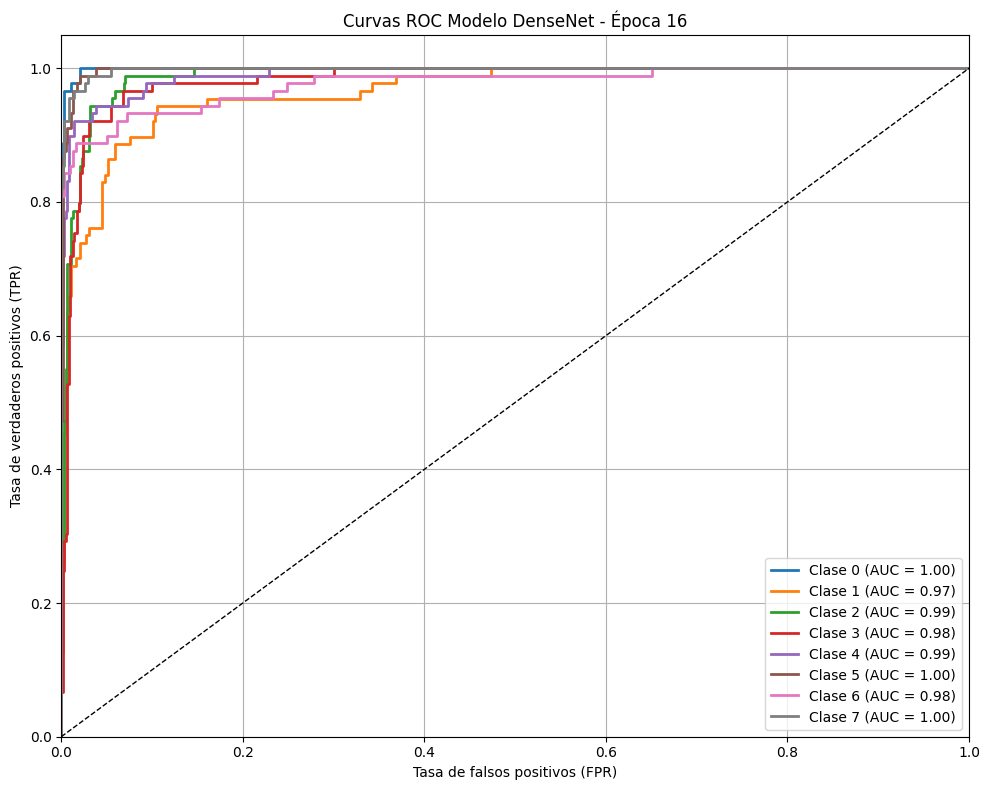

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_densenet121_3, classes=list(range(num_classes)))
y_score = np.array(prob_densenet121_3)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo DenseNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


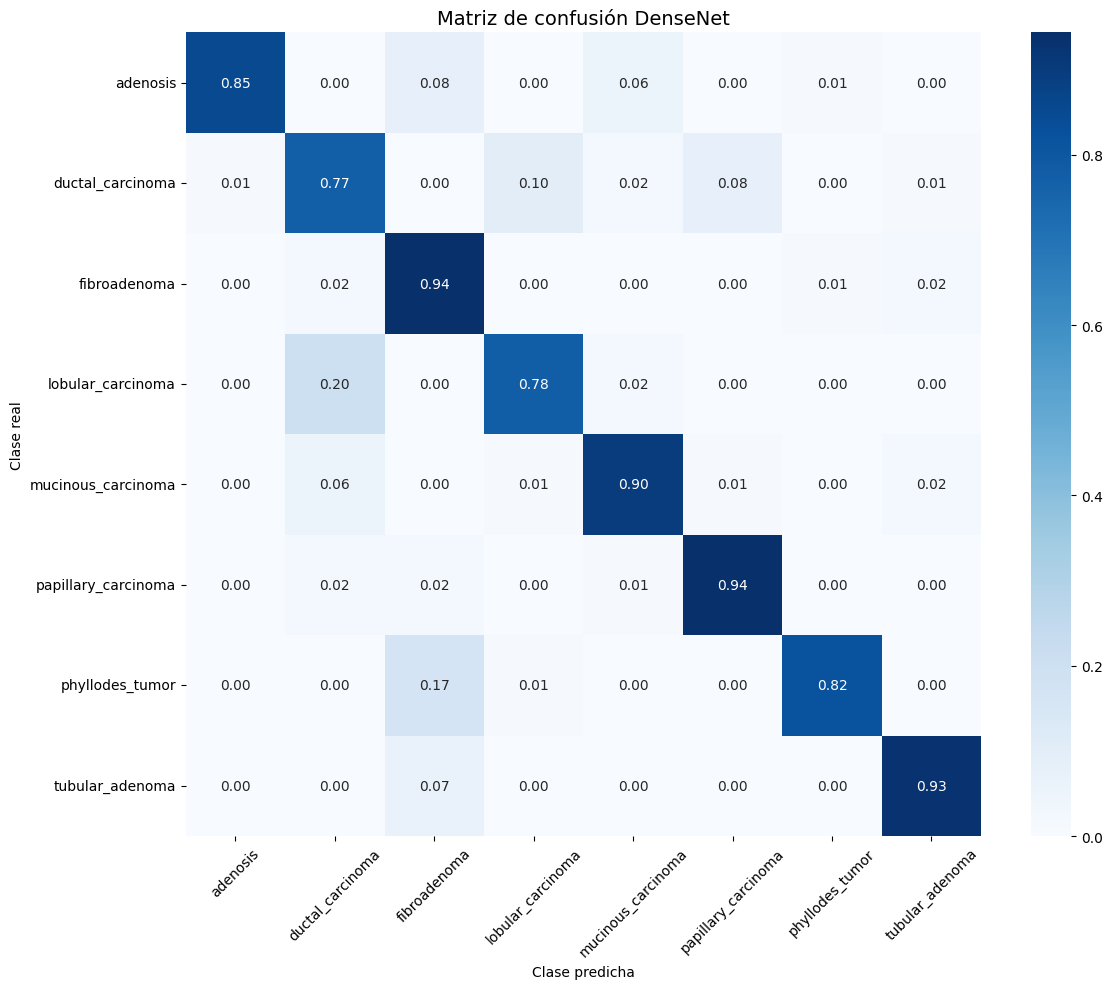

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_densenet121_3, pred_labels_densenet121_3)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión DenseNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

# =================================
# Modelo DenseNet121 preentrenado
# =================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo DenseNet121 preentrenado
# ==================================
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Test]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)


    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s]


Modelo modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.3919, Test Loss=0.8360, Test Acc=0.7215


Epoch 2: Train Loss=0.7156, Test Loss=0.5239, Test Acc=0.8172


Epoch 3: Train Loss=0.5163, Test Loss=0.4891, Test Acc=0.8453


Epoch 4: Train Loss=0.3918, Test Loss=0.3857, Test Acc=0.8650


Epoch 5: Train Loss=0.2992, Test Loss=0.3302, Test Acc=0.8805


Epoch 6: Train Loss=0.2456, Test Loss=0.3649, Test Acc=0.8847


Epoch 7: Train Loss=0.2116, Test Loss=0.3222, Test Acc=0.8889


Epoch 8: Train Loss=0.1556, Test Loss=0.3247, Test Acc=0.8973


Epoch 9: Train Loss=0.1663, Test Loss=0.3193, Test Acc=0.9072


Epoch 10: Train Loss=0.1266, Test Loss=0.3085, Test Acc=0.9030


Epoch 11: Train Loss=0.1177, Test Loss=0.3238, Test Acc=0.8973


Epoch 12: Train Loss=0.1005, Test Loss=0.3294, Test Acc=0.9015


Epoch 13: Train Loss=0.0977, Test Loss=0.3072, Test Acc=0.9001


Epoch 14: Train Loss=0.0839, Test Loss=0.3048, Test Acc=0.9030


Epoch 15 [Train]:  20%|██        | 18/89 [00:09<00:37,  1.91it/s]

In [ ]:
# Prueba 4
true_labels_densenet121_4 = true_labels_list
pred_labels_densenet121_4 = pred_labels_list
prob_densenet121_4 = prob_list

NameError: name 'true_labels_list' is not defined

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_densenet121_4 = accuracy_score(true_labels_densenet121_4, pred_labels_densenet121_4)
error_rate_densenet121_4 = 1 - acc_densenet121_4
print(f"Accuracy total: {acc_densenet121_4:.4f}, Error rate: {error_rate_densenet121_4:.4f}\n")

print(classification_report(
    true_labels_densenet121_4,
    pred_labels_densenet121_4,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_densenet121_4, classes=list(range(num_classes)))
y_score = np.array(prob_densenet121_4)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo DenseNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_densenet121_3, pred_labels_densenet121_3)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión DenseNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## MODEL GoogLeNet

In [39]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
# Congelar todos los parámetros
for param in model.parameters():
    param.requires_grad = False

# Reemplazar y entrenar solo la última capa fully connected
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Si usas las auxiliares
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Activar gradientes solo en esas capas
for param in model.fc.parameters():
    param.requires_grad = True
if model.aux_logits:
    for param in model.aux1.fc2.parameters():
        param.requires_grad = True
    for param in model.aux2.fc2.parameters():
        param.requires_grad = True

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================== Entrenamiento =============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=2.0638, Test Loss=2.0211, Test Acc=0.2180


Epoch 2: Train Loss=2.0014, Test Loss=1.9716, Test Acc=0.2644


Epoch 3: Train Loss=1.9520, Test Loss=1.9176, Test Acc=0.3319


Epoch 4: Train Loss=1.9080, Test Loss=1.8830, Test Acc=0.3418


Epoch 5: Train Loss=1.8649, Test Loss=1.8396, Test Acc=0.3952


Epoch 6: Train Loss=1.8276, Test Loss=1.8109, Test Acc=0.3727


Epoch 7: Train Loss=1.7932, Test Loss=1.7703, Test Acc=0.3980


Epoch 8: Train Loss=1.7599, Test Loss=1.7515, Test Acc=0.4051


Epoch 9: Train Loss=1.7337, Test Loss=1.7295, Test Acc=0.4135


Epoch 10: Train Loss=1.7104, Test Loss=1.7016, Test Acc=0.4388


Epoch 11: Train Loss=1.6805, Test Loss=1.6754, Test Acc=0.4360


Epoch 12: Train Loss=1.6583, Test Loss=1.6657, Test Acc=0.4262


Epoch 13: Train Loss=1.6324, Test Loss=1.6441, Test Acc=0.4332


Epoch 14: Train Loss=1.6158, Test Loss=1.6277, Test Acc=0.4543


Epoch 15: Train Loss=1.6017, Test Loss=1.6088, Test Acc=0.4571


Epoch 16: Train Loss=1.5922, Test Loss=1.5845, Test Acc=0.4641


Epoch 17: Train Loss=1.5700, Test Loss=1.5805, Test Acc=0.4515


Epoch 18: Train Loss=1.5521, Test Loss=1.5685, Test Acc=0.4740


Epoch 19: Train Loss=1.5459, Test Loss=1.5575, Test Acc=0.4726


Epoch 20: Train Loss=1.5297, Test Loss=1.5430, Test Acc=0.4684


Epoch 21: Train Loss=1.5214, Test Loss=1.5158, Test Acc=0.4768


Epoch 22: Train Loss=1.5111, Test Loss=1.5191, Test Acc=0.4669


Epoch 23: Train Loss=1.4890, Test Loss=1.5178, Test Acc=0.4796


Epoch 24: Train Loss=1.4883, Test Loss=1.4999, Test Acc=0.4796


Epoch 25: Train Loss=1.4675, Test Loss=1.4789, Test Acc=0.4909


Epoch 26: Train Loss=1.4567, Test Loss=1.4938, Test Acc=0.4810


Epoch 27: Train Loss=1.4518, Test Loss=1.4694, Test Acc=0.4852


Epoch 28: Train Loss=1.4457, Test Loss=1.4606, Test Acc=0.4866


Epoch 29: Train Loss=1.4389, Test Loss=1.4611, Test Acc=0.4979


Epoch 30: Train Loss=1.4390, Test Loss=1.4494, Test Acc=0.4923


Epoch 31: Train Loss=1.4162, Test Loss=1.4429, Test Acc=0.4993


Epoch 32: Train Loss=1.4115, Test Loss=1.4355, Test Acc=0.4923


Epoch 33: Train Loss=1.4020, Test Loss=1.4323, Test Acc=0.4923


Epoch 34: Train Loss=1.4068, Test Loss=1.4322, Test Acc=0.4979


Epoch 35: Train Loss=1.4025, Test Loss=1.4291, Test Acc=0.5091


Epoch 36: Train Loss=1.3768, Test Loss=1.4260, Test Acc=0.4951


Epoch 37: Train Loss=1.3741, Test Loss=1.4162, Test Acc=0.4866


Epoch 38: Train Loss=1.3734, Test Loss=1.4095, Test Acc=0.5063


Epoch 39: Train Loss=1.3728, Test Loss=1.4205, Test Acc=0.5007


Epoch 40: Train Loss=1.3695, Test Loss=1.3936, Test Acc=0.5176


Epoch 41: Train Loss=1.3676, Test Loss=1.3971, Test Acc=0.4951


Epoch 42: Train Loss=1.3418, Test Loss=1.4016, Test Acc=0.5091


Epoch 43: Train Loss=1.3397, Test Loss=1.4026, Test Acc=0.5007
🛑 Early stopping activado en la época 43


<All keys matched successfully>

In [40]:
# Prueba 1
true_labels_googlenet_1 = true_labels_list
pred_labels_googlenet_1 = pred_labels_list
prob_googlenet_1 = prob_list

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_googlenet_1 = accuracy_score(true_labels_googlenet_1, pred_labels_googlenet_1)
error_rate_googlenet_1 = 1 - acc_googlenet_1
print(f"Accuracy total: {acc_googlenet_1:.4f}, Error rate: {error_rate_googlenet_1:.4f}\n")

print(classification_report(
    true_labels_googlenet_1,
    pred_labels_googlenet_1,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.5007, Error rate: 0.4993

                     precision    recall  f1-score   support

           adenosis       0.54      0.71      0.61        89
   ductal_carcinoma       0.38      0.41      0.39        88
       fibroadenoma       0.44      0.47      0.45        89
  lobular_carcinoma       0.62      0.43      0.51        89
 mucinous_carcinoma       0.54      0.39      0.45        89
papillary_carcinoma       0.52      0.39      0.45        89
    phyllodes_tumor       0.55      0.58      0.57        89
    tubular_adenoma       0.48      0.62      0.54        89

           accuracy                           0.50       711
          macro avg       0.51      0.50      0.50       711
       weighted avg       0.51      0.50      0.50       711



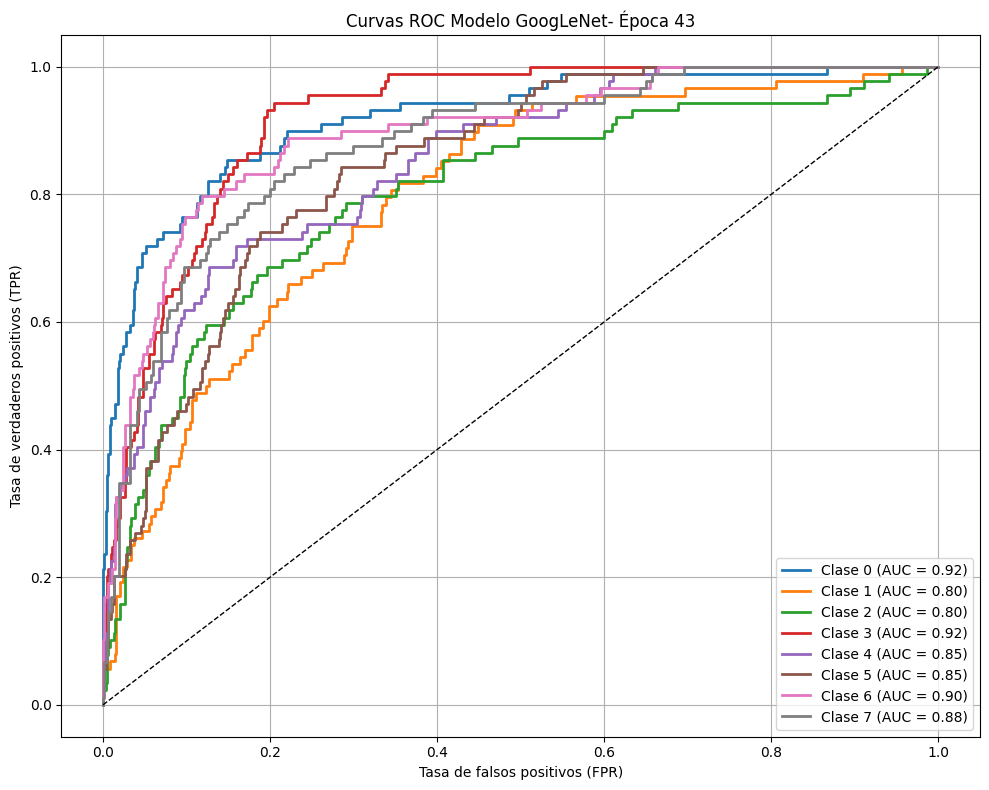

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_googlenet_1, classes=list(range(num_classes)))
y_score = np.array(prob_googlenet_1)

# Curva ROC por clase
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo GoogLeNet- Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

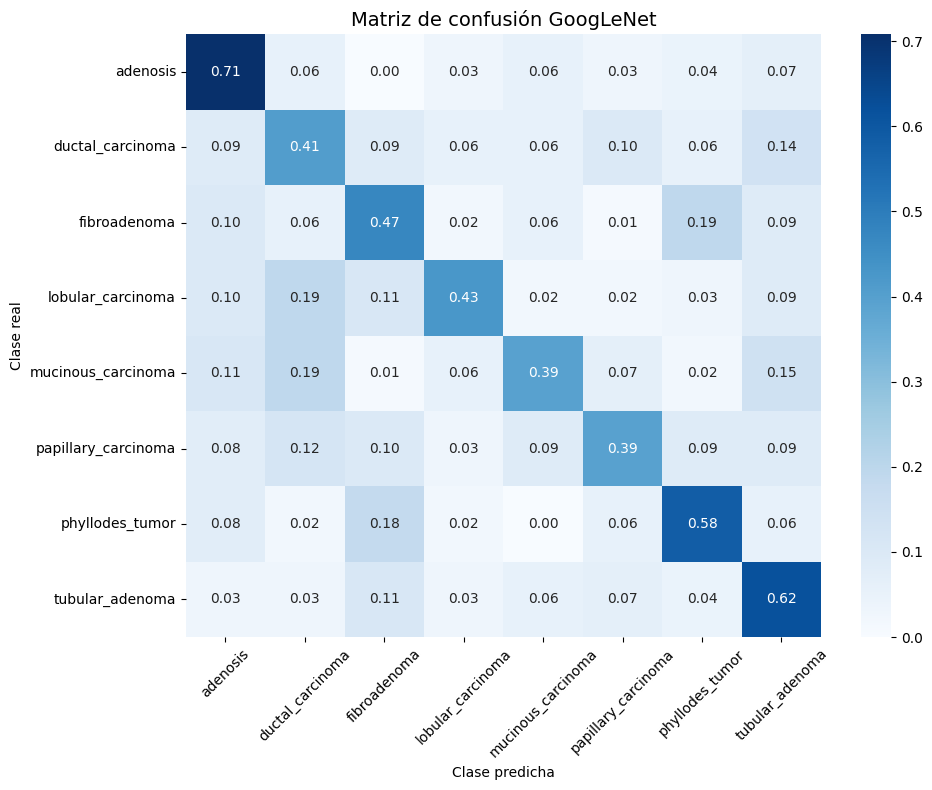

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_googlenet_1, pred_labels_googlenet_1)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión GoogLeNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [32]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True


# Reemplazar la capa fully connected final
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Reemplazar las salidas auxiliares si se usan
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.7216, Test Loss=1.3015, Test Acc=0.5457


Epoch 2: Train Loss=0.9948, Test Loss=0.8620, Test Acc=0.7060


Epoch 3: Train Loss=0.5653, Test Loss=0.7305, Test Acc=0.7257


Epoch 4: Train Loss=0.3038, Test Loss=0.6840, Test Acc=0.7525


Epoch 5: Train Loss=0.1649, Test Loss=0.6218, Test Acc=0.7792


Epoch 6: Train Loss=0.0974, Test Loss=0.6441, Test Acc=0.7750


Epoch 7: Train Loss=0.0599, Test Loss=0.6390, Test Acc=0.7848


Epoch 8: Train Loss=0.0426, Test Loss=0.6652, Test Acc=0.7890
🛑 Early stopping activado en la época 8


<All keys matched successfully>

In [33]:
# Prueba 2
true_labels_googlenet_2 = true_labels_list
pred_labels_googlenet_2 = pred_labels_list
prob_googlenet_2 = prob_list

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_googlenet_2 = accuracy_score(true_labels_googlenet_2, pred_labels_googlenet_2)
error_rate_googlenet_2 = 1 - acc_googlenet_2
print(f"Accuracy total: {acc_googlenet_2:.4f}, Error rate: {error_rate_googlenet_2:.4f}\n")

print(classification_report(
    true_labels_googlenet_2,
    pred_labels_googlenet_2,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.7890, Error rate: 0.2110

                     precision    recall  f1-score   support

           adenosis       0.91      0.88      0.89        89
   ductal_carcinoma       0.83      0.65      0.73        88
       fibroadenoma       0.72      0.63      0.67        89
  lobular_carcinoma       0.77      0.89      0.83        89
 mucinous_carcinoma       0.73      0.75      0.74        89
papillary_carcinoma       0.80      0.80      0.80        89
    phyllodes_tumor       0.70      0.87      0.77        89
    tubular_adenoma       0.89      0.85      0.87        89

           accuracy                           0.79       711
          macro avg       0.79      0.79      0.79       711
       weighted avg       0.79      0.79      0.79       711



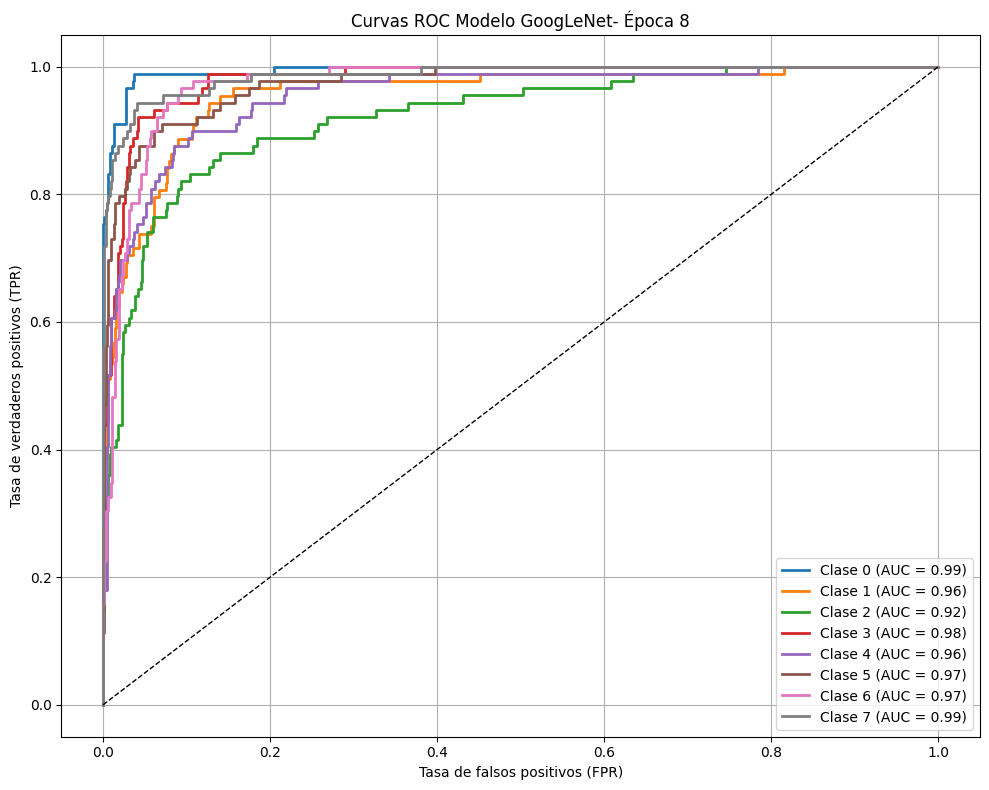

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_googlenet_2, classes=list(range(num_classes)))
y_score = np.array(prob_googlenet_2)

# Curva ROC por clase
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo GoogLeNet- Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

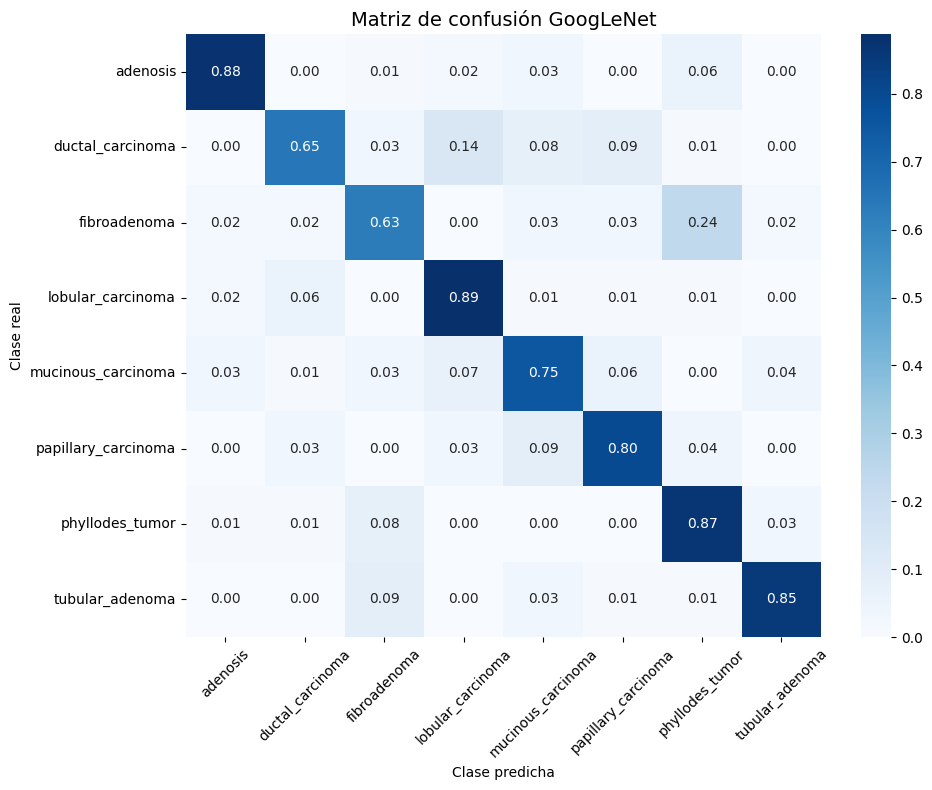

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_googlenet_2, pred_labels_googlenet_2)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión GoogLeNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
# Congelar todos los parámetros
for param in model.parameters():
    param.requires_grad = False

# Reemplazar y entrenar solo la última capa fully connected
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Si usas las auxiliares
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Activar gradientes solo en esas capas
for param in model.fc.parameters():
    param.requires_grad = True
if model.aux_logits:
    for param in model.aux1.fc2.parameters():
        param.requires_grad = True
    for param in model.aux2.fc2.parameters():
        param.requires_grad = True

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=5e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================== Entrenamiento =============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1 [Train]:  69%|██████▊   | 61/89 [00:02<00:01, 26.45it/s]

In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la capa fully connected final
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Reemplazar las salidas auxiliares si se usan
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Val]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)

    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.7749, Val Loss=1.3906, Val Acc=0.5148


Epoch 2: Train Loss=1.1021, Val Loss=0.8569, Val Acc=0.7117


Epoch 3: Train Loss=0.7925, Val Loss=0.6631, Val Acc=0.7595


Epoch 4: Train Loss=0.6085, Val Loss=0.5683, Val Acc=0.7975


Epoch 5: Train Loss=0.5151, Val Loss=0.5410, Val Acc=0.8073


Epoch 6: Train Loss=0.4399, Val Loss=0.4776, Val Acc=0.8298


Epoch 7: Train Loss=0.3759, Val Loss=0.4848, Val Acc=0.8368


Epoch 8: Train Loss=0.3126, Val Loss=0.4449, Val Acc=0.8383


Epoch 9: Train Loss=0.2596, Val Loss=0.4437, Val Acc=0.8523


Epoch 10: Train Loss=0.2221, Val Loss=0.4023, Val Acc=0.8537


Epoch 11: Train Loss=0.1998, Val Loss=0.4189, Val Acc=0.8425


Epoch 12: Train Loss=0.1951, Val Loss=0.4623, Val Acc=0.8551


Epoch 13: Train Loss=0.1787, Val Loss=0.4291, Val Acc=0.8481
🛑 Early stopping en epoch 13


<All keys matched successfully>

In [ ]:
# Prueba 3
true_labels_googlenet_3 = true_labels_list
pred_labels_googlenet_3 = pred_labels_list
prob_googlenet_3 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_googlenet_3 = accuracy_score(true_labels_googlenet_3, pred_labels_googlenet_3)
error_rate_googlenet_3 = 1 - acc_googlenet_3
print(f"Accuracy total: {acc_googlenet_3:.4f}, Error rate: {error_rate_googlenet_3:.4f}\n")

print(classification_report(
    true_labels_googlenet_3,
    pred_labels_googlenet_3,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8481, Error rate: 0.1519

                     precision    recall  f1-score   support

           adenosis       0.91      0.97      0.93        89
   ductal_carcinoma       0.75      0.78      0.77        88
       fibroadenoma       0.87      0.74      0.80        89
  lobular_carcinoma       0.82      0.75      0.78        89
 mucinous_carcinoma       0.86      0.79      0.82        89
papillary_carcinoma       0.90      0.94      0.92        89
    phyllodes_tumor       0.80      0.88      0.83        89
    tubular_adenoma       0.88      0.93      0.91        89

           accuracy                           0.85       711
          macro avg       0.85      0.85      0.85       711
       weighted avg       0.85      0.85      0.85       711



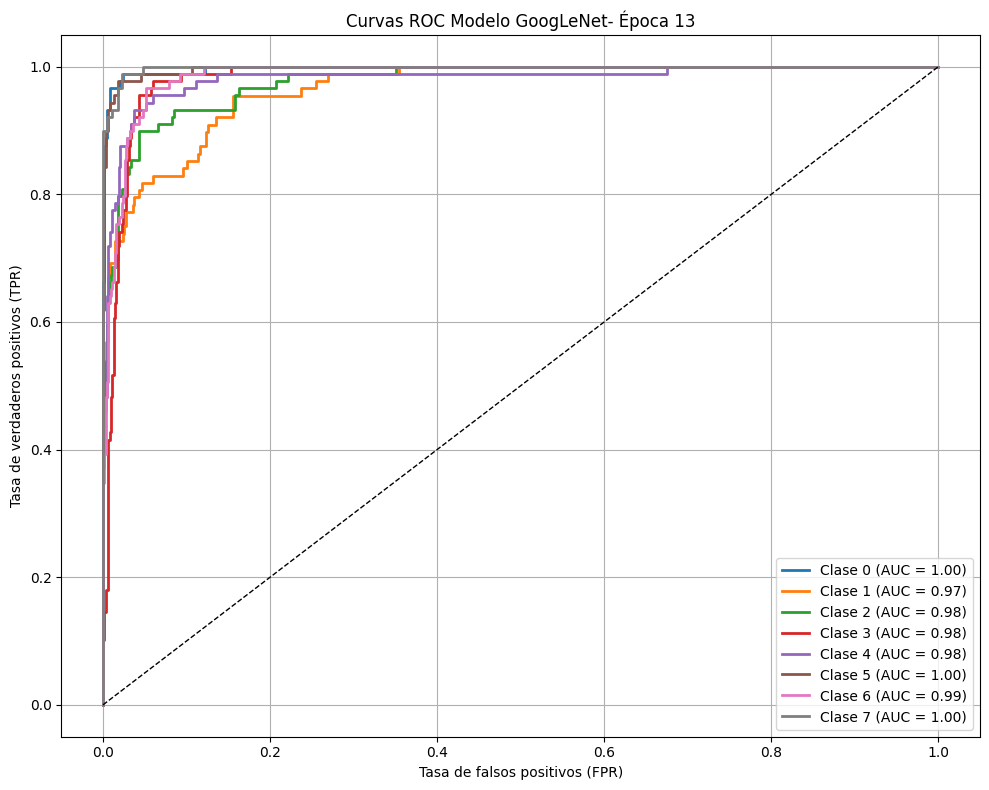

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_googlenet_3, classes=list(range(num_classes)))
y_score = np.array(prob_googlenet_3)

# Curva ROC por clase
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo GoogLeNet- Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

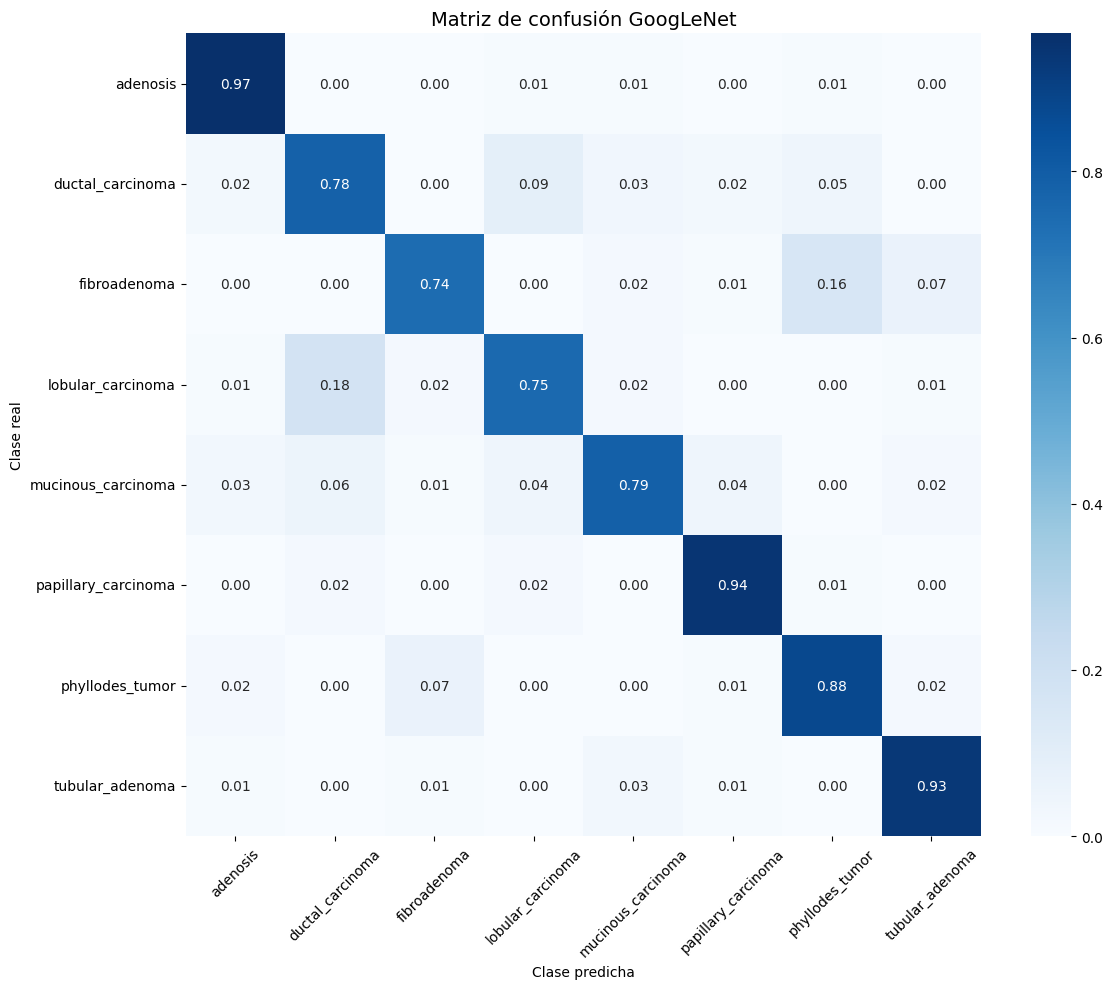

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_googlenet_3, pred_labels_googlenet_3)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión GoogLeNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [8]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True


# Reemplazar la capa fully connected final
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Reemplazar las salidas auxiliares si se usan
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping activado en la época {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 150MB/s]


Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=2.0799, Test Loss=2.0108, Test Acc=0.2194


Epoch 2: Train Loss=1.9592, Test Loss=1.9111, Test Acc=0.3263


Epoch 3: Train Loss=1.8544, Test Loss=1.8106, Test Acc=0.3980


Epoch 4: Train Loss=1.7417, Test Loss=1.7007, Test Acc=0.4655


Epoch 5: Train Loss=1.6197, Test Loss=1.5966, Test Acc=0.5021


Epoch 6: Train Loss=1.5009, Test Loss=1.4926, Test Acc=0.5232


Epoch 7: Train Loss=1.3887, Test Loss=1.4015, Test Acc=0.5556


Epoch 8: Train Loss=1.2771, Test Loss=1.2979, Test Acc=0.5963


Epoch 9: Train Loss=1.1898, Test Loss=1.2257, Test Acc=0.6076


Epoch 10: Train Loss=1.0881, Test Loss=1.1579, Test Acc=0.6231


Epoch 11: Train Loss=0.9975, Test Loss=1.0951, Test Acc=0.6343


Epoch 12: Train Loss=0.9215, Test Loss=1.0515, Test Acc=0.6540


Epoch 13: Train Loss=0.8527, Test Loss=1.0018, Test Acc=0.6681


Epoch 14: Train Loss=0.8026, Test Loss=0.9627, Test Acc=0.6624


Epoch 15: Train Loss=0.7311, Test Loss=0.9353, Test Acc=0.6709


Epoch 16: Train Loss=0.6737, Test Loss=0.9011, Test Acc=0.6850


Epoch 17: Train Loss=0.6251, Test Loss=0.8687, Test Acc=0.6864


Epoch 18: Train Loss=0.5635, Test Loss=0.8497, Test Acc=0.7018


Epoch 19: Train Loss=0.5308, Test Loss=0.8366, Test Acc=0.7117


Epoch 20: Train Loss=0.4846, Test Loss=0.8148, Test Acc=0.7145


Epoch 21: Train Loss=0.4349, Test Loss=0.8103, Test Acc=0.7117


Epoch 22: Train Loss=0.4005, Test Loss=0.7849, Test Acc=0.7103


Epoch 23: Train Loss=0.3817, Test Loss=0.7756, Test Acc=0.7201


Epoch 24: Train Loss=0.3339, Test Loss=0.7635, Test Acc=0.7201


Epoch 25: Train Loss=0.3061, Test Loss=0.7597, Test Acc=0.7215


Epoch 26: Train Loss=0.2753, Test Loss=0.7507, Test Acc=0.7187


Epoch 27: Train Loss=0.2550, Test Loss=0.7364, Test Acc=0.7257


Epoch 28: Train Loss=0.2349, Test Loss=0.7325, Test Acc=0.7286


Epoch 29: Train Loss=0.2009, Test Loss=0.7280, Test Acc=0.7229


Epoch 30: Train Loss=0.1853, Test Loss=0.7321, Test Acc=0.7412


Epoch 31: Train Loss=0.1700, Test Loss=0.7297, Test Acc=0.7271


Epoch 32: Train Loss=0.1552, Test Loss=0.7279, Test Acc=0.7271
🛑 Early stopping activado en la época 32


<All keys matched successfully>

In [9]:
# Prueba 4
true_labels_googlenet_4LR = true_labels_list
pred_labels_googlenet_4LR = pred_labels_list
prob_googlenet_4LR = prob_list

In [ ]:
import os
from PIL import Image
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo GoogLeNet preentrenado
# ==================================
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la capa fully connected final
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Reemplazar las salidas auxiliares si se usan
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

print(f"Modelo googlenet modificado (última capa): {model.fc}")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Val]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)

    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo googlenet modificado (última capa): Linear(in_features=1024, out_features=8, bias=True)


Epoch 1: Train Loss=1.7220, Val Loss=1.3190, Val Acc=0.5626


Epoch 2: Train Loss=1.0892, Val Loss=0.8480, Val Acc=0.7187


Epoch 3: Train Loss=0.7703, Val Loss=0.6241, Val Acc=0.7707


Epoch 4: Train Loss=0.6012, Val Loss=0.5440, Val Acc=0.7932


Epoch 5: Train Loss=0.4989, Val Loss=0.4946, Val Acc=0.8284


Epoch 6: Train Loss=0.4235, Val Loss=0.5122, Val Acc=0.8284


Epoch 7: Train Loss=0.3619, Val Loss=0.4341, Val Acc=0.8495


Epoch 8: Train Loss=0.3106, Val Loss=0.4233, Val Acc=0.8439


Epoch 9: Train Loss=0.2611, Val Loss=0.4328, Val Acc=0.8579


Epoch 10: Train Loss=0.2243, Val Loss=0.4205, Val Acc=0.8481


Epoch 11: Train Loss=0.1900, Val Loss=0.4157, Val Acc=0.8467


Epoch 12: Train Loss=0.1642, Val Loss=0.4054, Val Acc=0.8636


Epoch 13: Train Loss=0.1574, Val Loss=0.4571, Val Acc=0.8551


Epoch 14: Train Loss=0.1548, Val Loss=0.4235, Val Acc=0.8720


Epoch 15: Train Loss=0.1511, Val Loss=0.3659, Val Acc=0.8748


Epoch 16: Train Loss=0.1189, Val Loss=0.4060, Val Acc=0.8678


Epoch 17: Train Loss=0.1059, Val Loss=0.3517, Val Acc=0.8945


Epoch 18: Train Loss=0.0974, Val Loss=0.4094, Val Acc=0.8720


Epoch 19: Train Loss=0.1004, Val Loss=0.3926, Val Acc=0.8706


Epoch 20: Train Loss=0.1056, Val Loss=0.4176, Val Acc=0.8608
🛑 Early stopping en epoch 20


<All keys matched successfully>

In [ ]:
# Prueba 4
true_labels_googlenet_4 = true_labels_list
pred_labels_googlenet_4 = pred_labels_list
prob_googlenet_4 = prob_list

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_googlenet_4 = accuracy_score(true_labels_googlenet_4, pred_labels_googlenet_4)
error_rate_googlenet_4 = 1 - acc_googlenet_4
print(f"Accuracy total: {acc_googlenet_4:.4f}, Error rate: {error_rate_googlenet_4:.4f}\n")

print(classification_report(
    true_labels_googlenet_4,
    pred_labels_googlenet_4,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.8608, Error rate: 0.1392

                     precision    recall  f1-score   support

           adenosis       0.89      0.97      0.92        89
   ductal_carcinoma       0.81      0.76      0.78        88
       fibroadenoma       0.89      0.64      0.75        89
  lobular_carcinoma       0.83      0.82      0.82        89
 mucinous_carcinoma       0.95      0.85      0.90        89
papillary_carcinoma       0.87      0.94      0.90        89
    phyllodes_tumor       0.81      0.90      0.85        89
    tubular_adenoma       0.86      1.00      0.93        89

           accuracy                           0.86       711
          macro avg       0.86      0.86      0.86       711
       weighted avg       0.86      0.86      0.86       711



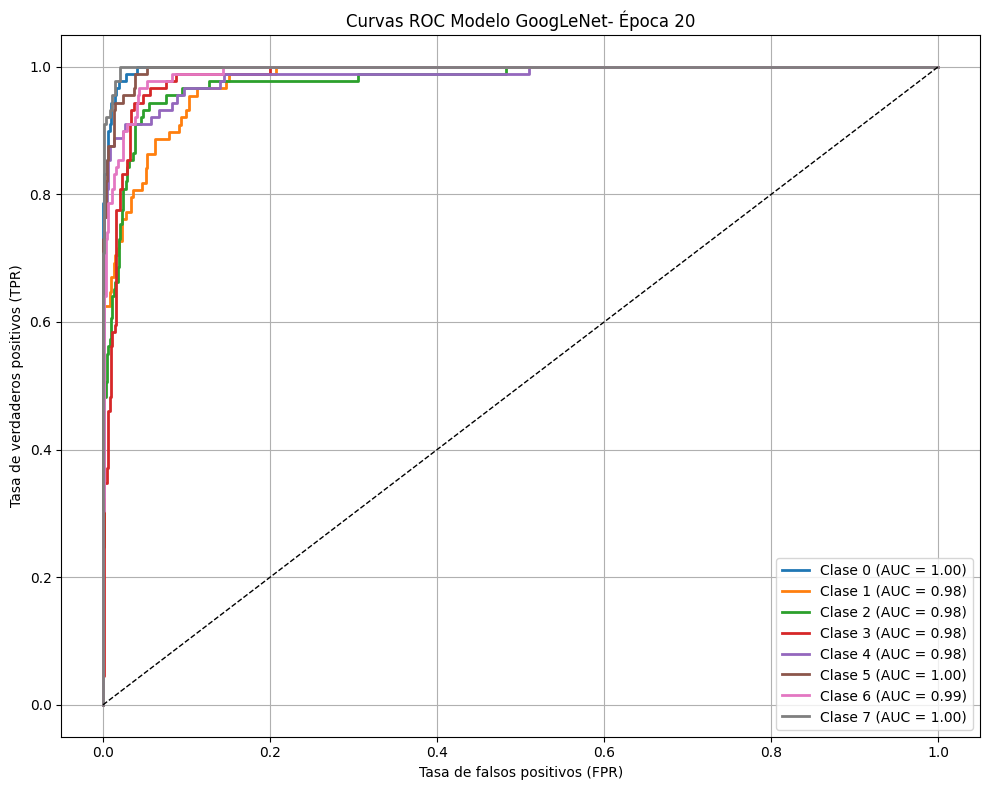

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_googlenet_4, classes=list(range(num_classes)))
y_score = np.array(prob_googlenet_4)

# Curva ROC por clase
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo GoogLeNet- Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

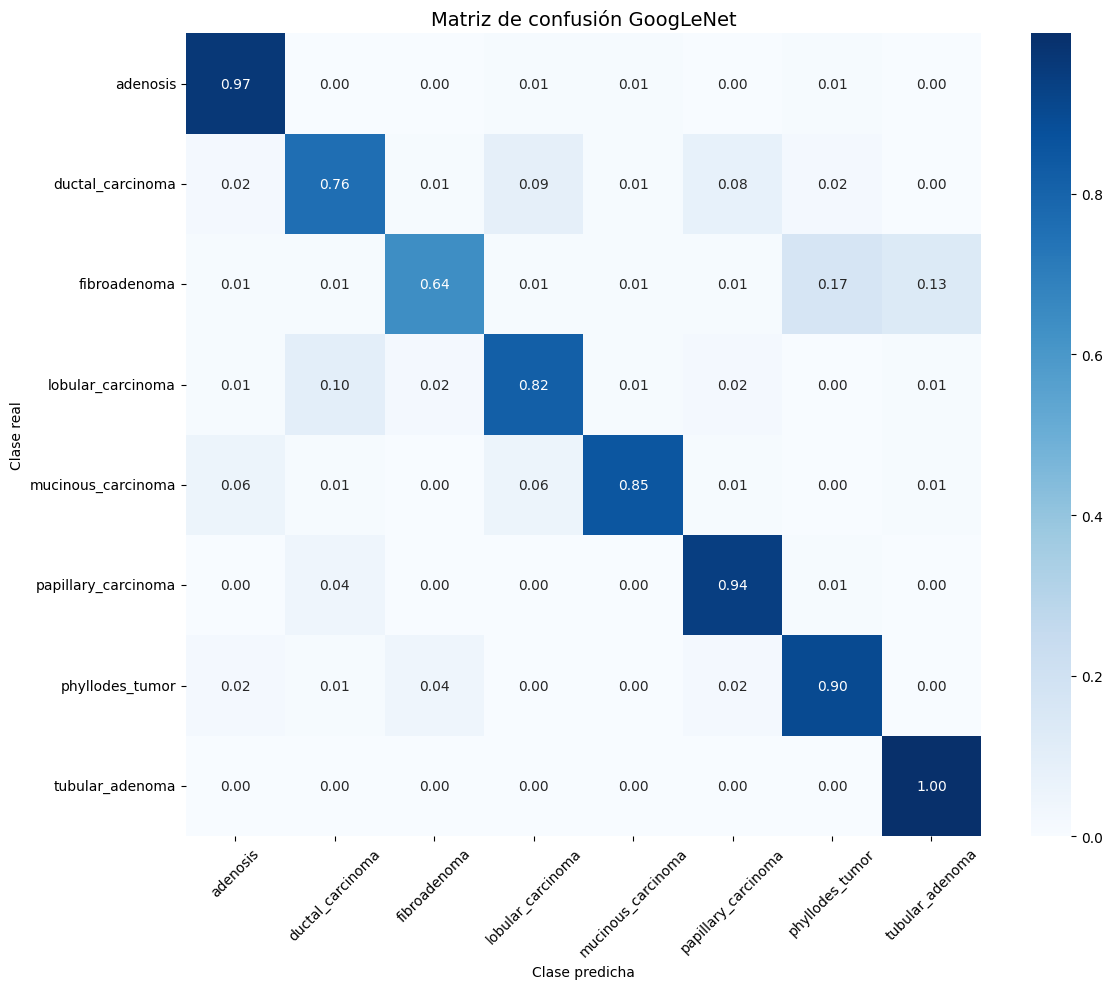

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_googlenet_4, pred_labels_googlenet_4)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión GoogLeNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## MODEL AlexNet

In [10]:
import os
from PIL import Image
import torch
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo AlexNet preentrenado
# ==================================
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la última capa del clasificador
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}\n")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 174MB/s]


Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=1.6546, Test Loss=1.3182, Test Acc=0.5120


Epoch 2: Train Loss=1.2224, Test Loss=1.2682, Test Acc=0.5204


Epoch 3: Train Loss=0.9961, Test Loss=1.0473, Test Acc=0.6076


Epoch 4: Train Loss=0.8093, Test Loss=0.9919, Test Acc=0.6385


Epoch 5: Train Loss=0.6566, Test Loss=1.1464, Test Acc=0.5640


Epoch 6: Train Loss=0.5583, Test Loss=0.9996, Test Acc=0.6231


Epoch 7: Train Loss=0.4444, Test Loss=1.0443, Test Acc=0.6160
🛑 Early stopping en epoch 7


<All keys matched successfully>

In [ ]:
# import os
# from PIL import Image
# import torch
# from torchvision.models import alexnet, AlexNet_Weights
# import torchvision.transforms as transforms
# from torch.utils.data import TensorDataset, DataLoader
# from torchvision import models
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm

# # ==================================
# # Modelo AlexNet preentrenado
# # ==================================
# model = alexnet(weights=AlexNet_Weights.DEFAULT)

# # ==============================================================================
# # Sin fine-tuning (congelar capas convolucionales)
# # ==============================================================================
# # Solo las capas convolucionales
# for param in model.features.parameters():
#     param.requires_grad = False

# # Reemplazar la última capa del clasificador
# model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
# print(f"Modelo modificado (última capa): {model.classifier}\n")
# model = model.to(device)

# # ==============================================================================
# # Función de pérdida y optimizador
# # ==============================================================================
# criterion = nn.CrossEntropyLoss()
# # Solo se optimiza la capa final
# optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# # ==============================================================================
# # Parámetros Early Stopping
# # ==============================================================================
# patience = 3
# min_delta = 0.001
# best_val_loss = float("inf")
# patience_counter = 0
# best_model_wts = None

# # ==============================================================================
# # Entrenamiento dataloader + Evaluación
# # ==============================================================================
# epochs = 50

# for epoch in range(epochs):
#     # ============================= Entrenamiento ==============================
#     model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     train_loss = running_loss / len(train_loader_32)

#     # =============================== Evaluación ===============================
#     model.eval()
#     val_loss = 0.0
#     correct, total = 0, 0
#     true_labels_list, pred_labels_list, prob_list = [], [], []

#     with torch.no_grad():
#         for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)

#             # Pérdida para early stopping
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             # Probabilidades y predicciones
#             probs = torch.softmax(outputs, dim=1)
#             preds = torch.argmax(probs, dim=1)

#             # Guardar para métricas finales
#             true_labels_list.extend(labels.cpu().numpy())
#             pred_labels_list.extend(preds.cpu().numpy())
#             prob_list.extend(probs.cpu().numpy())

#             # Accuracy temporal
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     val_loss /= len(test_loader_32)
#     val_acc = correct / total
#     print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

#     # ============================= Early Stopping =============================
#     if val_loss < best_val_loss - min_delta:
#         best_val_loss = val_loss
#         patience_counter = 0
#         best_model_wts = model.state_dict()
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print(f"🛑 Early stopping en epoch {epoch+1}")
#             break

# # =========================
# # Restaurar mejores pesos
# # =========================
# model.load_state_dict(best_model_wts)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:07<00:00, 31.0MB/s]


Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=1.6298, Test Loss=1.2074, Test Acc=0.5401


Epoch 2: Train Loss=1.0389, Test Loss=0.9051, Test Acc=0.6723


Epoch 3: Train Loss=0.7806, Test Loss=0.8899, Test Acc=0.6681


Epoch 4: Train Loss=0.5313, Test Loss=0.7434, Test Acc=0.7356


Epoch 5: Train Loss=0.4060, Test Loss=0.7585, Test Acc=0.7145


Epoch 6: Train Loss=0.2489, Test Loss=0.9944, Test Acc=0.6934


Epoch 7: Train Loss=0.2366, Test Loss=0.7237, Test Acc=0.7539


Epoch 8: Train Loss=0.1531, Test Loss=0.8150, Test Acc=0.7496


Epoch 9: Train Loss=0.1251, Test Loss=0.9743, Test Acc=0.7187


Epoch 10: Train Loss=0.1081, Test Loss=0.9470, Test Acc=0.7257
🛑 Early stopping en epoch 10


<All keys matched successfully>

In [11]:
# Prueba 1
true_labels_alexnet_1 = true_labels_list
pred_labels_alexnet_1 = pred_labels_list
prob_alexnet_1 = prob_list

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_alexnet_1 = accuracy_score(true_labels_alexnet_1, pred_labels_alexnet_1)
error_rate_alexnet_1 = 1 - acc_alexnet_1
print(f"Accuracy total: {acc_alexnet_1:.4f}, Error rate: {error_rate_alexnet_1:.4f}\n")

print(classification_report(
    true_labels_alexnet_1,
    pred_labels_alexnet_1,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.6160, Error rate: 0.3840

                     precision    recall  f1-score   support

           adenosis       0.79      0.87      0.83        89
   ductal_carcinoma       0.45      0.66      0.54        88
       fibroadenoma       0.44      0.54      0.49        89
  lobular_carcinoma       0.74      0.56      0.64        89
 mucinous_carcinoma       0.74      0.39      0.51        89
papillary_carcinoma       0.61      0.73      0.66        89
    phyllodes_tumor       0.58      0.60      0.59        89
    tubular_adenoma       0.80      0.58      0.68        89

           accuracy                           0.62       711
          macro avg       0.65      0.62      0.62       711
       weighted avg       0.65      0.62      0.62       711



In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_alexnet_1 = accuracy_score(true_labels_alexnet_1, pred_labels_alexnet_1)
error_rate_alexnet_1 = 1 - acc_alexnet_1
print(f"Accuracy total: {acc_alexnet_1:.4f}, Error rate: {error_rate_alexnet_1:.4f}\n")

print(classification_report(
    true_labels_alexnet_1,
    pred_labels_alexnet_1,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.6160, Error rate: 0.3840

                     precision    recall  f1-score   support

           adenosis       0.79      0.87      0.83        89
   ductal_carcinoma       0.45      0.66      0.54        88
       fibroadenoma       0.44      0.54      0.49        89
  lobular_carcinoma       0.74      0.56      0.64        89
 mucinous_carcinoma       0.74      0.39      0.51        89
papillary_carcinoma       0.61      0.73      0.66        89
    phyllodes_tumor       0.58      0.60      0.59        89
    tubular_adenoma       0.80      0.58      0.68        89

           accuracy                           0.62       711
          macro avg       0.65      0.62      0.62       711
       weighted avg       0.65      0.62      0.62       711



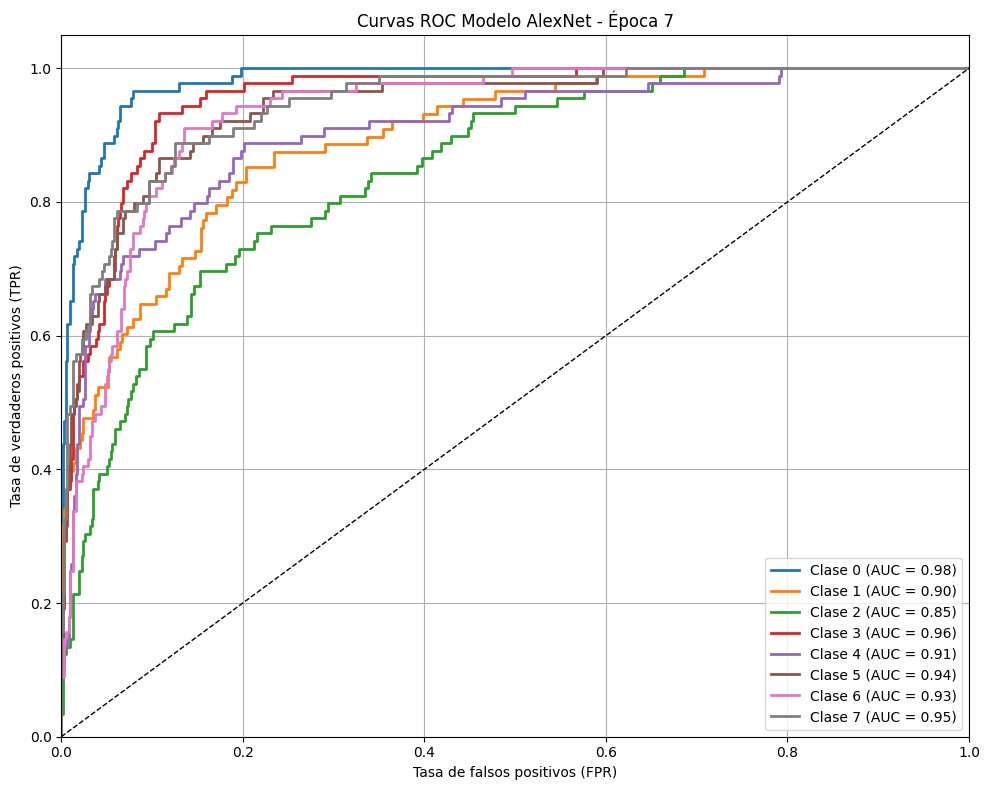

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_alexnet_1, classes=list(range(num_classes)))
y_score = np.array(prob_alexnet_1)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo AlexNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


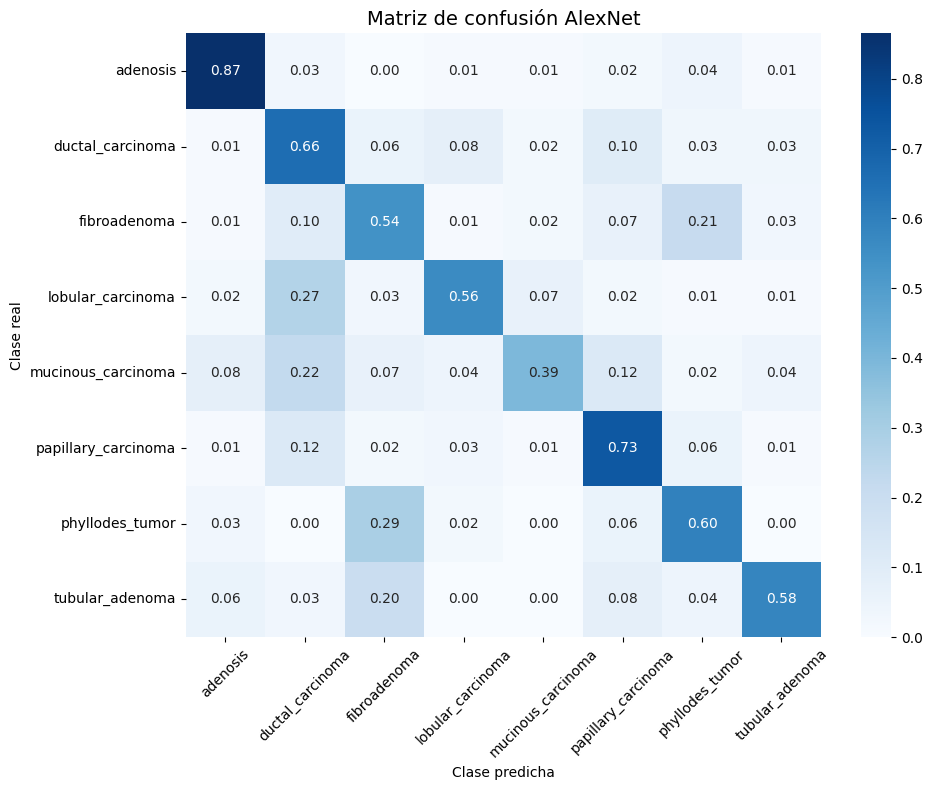

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_alexnet_1, pred_labels_alexnet_1)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión AlexNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [16]:
import os
from PIL import Image
import torch
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo AlexNet preentrenado
# ==================================
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}\n")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================== Entrenamiento =============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=1.6249, Test Loss=1.2378, Test Acc=0.5359


Epoch 2: Train Loss=1.0894, Test Loss=0.9185, Test Acc=0.6681


Epoch 3: Train Loss=0.7844, Test Loss=0.8702, Test Acc=0.6639


Epoch 4: Train Loss=0.5518, Test Loss=0.7637, Test Acc=0.7314


Epoch 5: Train Loss=0.4111, Test Loss=0.7298, Test Acc=0.7412


Epoch 6: Train Loss=0.2478, Test Loss=0.8966, Test Acc=0.7229


Epoch 7: Train Loss=0.2292, Test Loss=0.7812, Test Acc=0.7300


Epoch 8: Train Loss=0.1644, Test Loss=0.7971, Test Acc=0.7609
🛑 Early stopping en epoch 8


<All keys matched successfully>

In [17]:
# Prueba 2
true_labels_alexnet_2 = true_labels_list
pred_labels_alexnet_2 = pred_labels_list
prob_alexnet_2 = prob_list

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_alexnet_2 = accuracy_score(true_labels_alexnet_2, pred_labels_alexnet_2)
error_rate_alexnet_2 = 1 - acc_alexnet_2
print(f"Accuracy total: {acc_alexnet_2:.4f}, Error rate: {error_rate_alexnet_2:.4f}\n")

print(classification_report(
    true_labels_alexnet_2,
    pred_labels_alexnet_2,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.7609, Error rate: 0.2391

                     precision    recall  f1-score   support

           adenosis       0.94      0.85      0.89        89
   ductal_carcinoma       0.78      0.59      0.67        88
       fibroadenoma       0.61      0.80      0.69        89
  lobular_carcinoma       0.70      0.92      0.80        89
 mucinous_carcinoma       0.77      0.62      0.69        89
papillary_carcinoma       0.85      0.72      0.78        89
    phyllodes_tumor       0.74      0.75      0.75        89
    tubular_adenoma       0.79      0.83      0.81        89

           accuracy                           0.76       711
          macro avg       0.77      0.76      0.76       711
       weighted avg       0.77      0.76      0.76       711



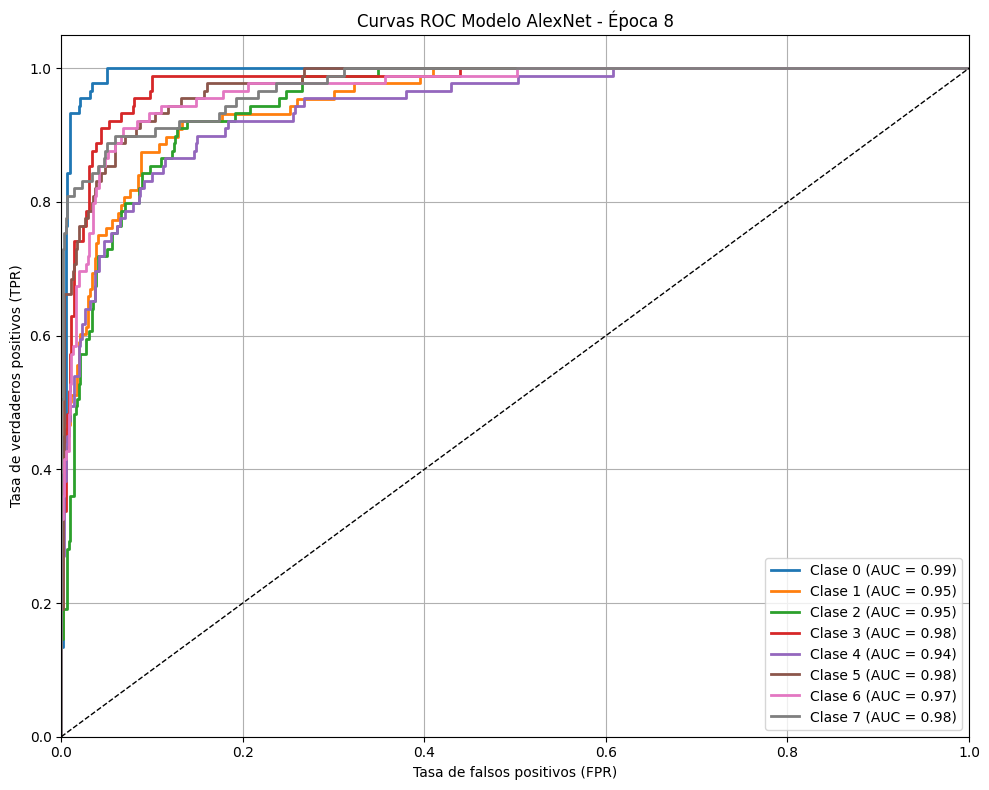

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_alexnet_2, classes=list(range(num_classes)))
y_score = np.array(prob_alexnet_2)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo AlexNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


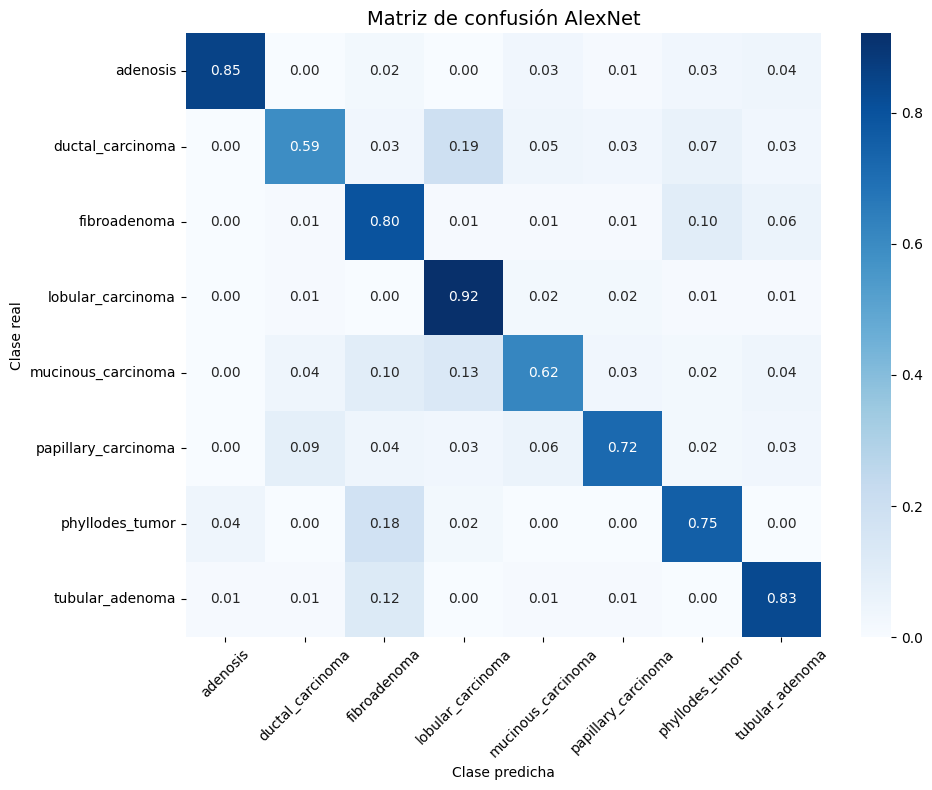

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_alexnet_2, pred_labels_alexnet_2)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión AlexNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [21]:
import os
from PIL import Image
import torch
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo AlexNet preentrenado
# ==================================
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# ==============================================================================
# Sin fine-tuning (congelar capas convolucionales)
# ==============================================================================
# Solo las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

# Reemplazar la última capa del clasificador
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}\n")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Solo se optimiza la capa final
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)



Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=2.1006, Test Loss=2.0792, Test Acc=0.1477


Epoch 2: Train Loss=2.0324, Test Loss=2.0210, Test Acc=0.1828


Epoch 3: Train Loss=1.9879, Test Loss=1.9721, Test Acc=0.2194


Epoch 4: Train Loss=1.9473, Test Loss=1.9280, Test Acc=0.2658


Epoch 5: Train Loss=1.9039, Test Loss=1.8892, Test Acc=0.2940


Epoch 6: Train Loss=1.8779, Test Loss=1.8537, Test Acc=0.3150


Epoch 7: Train Loss=1.8470, Test Loss=1.8224, Test Acc=0.3418


Epoch 8: Train Loss=1.8063, Test Loss=1.7936, Test Acc=0.3460


Epoch 9: Train Loss=1.7870, Test Loss=1.7676, Test Acc=0.3558


Epoch 10: Train Loss=1.7680, Test Loss=1.7438, Test Acc=0.3755


Epoch 11: Train Loss=1.7573, Test Loss=1.7220, Test Acc=0.3910


Epoch 12: Train Loss=1.7284, Test Loss=1.7022, Test Acc=0.4023


Epoch 13: Train Loss=1.7140, Test Loss=1.6821, Test Acc=0.4107


Epoch 14: Train Loss=1.6983, Test Loss=1.6650, Test Acc=0.4219


Epoch 15: Train Loss=1.6714, Test Loss=1.6504, Test Acc=0.4290


Epoch 16: Train Loss=1.6653, Test Loss=1.6345, Test Acc=0.4290


Epoch 17: Train Loss=1.6481, Test Loss=1.6196, Test Acc=0.4346


Epoch 18: Train Loss=1.6380, Test Loss=1.6069, Test Acc=0.4346


Epoch 19: Train Loss=1.6220, Test Loss=1.5926, Test Acc=0.4473


Epoch 20: Train Loss=1.6182, Test Loss=1.5818, Test Acc=0.4444


Epoch 21: Train Loss=1.6024, Test Loss=1.5692, Test Acc=0.4543


Epoch 22: Train Loss=1.5881, Test Loss=1.5599, Test Acc=0.4557


Epoch 23: Train Loss=1.5839, Test Loss=1.5491, Test Acc=0.4599


Epoch 24: Train Loss=1.5855, Test Loss=1.5399, Test Acc=0.4641


Epoch 25: Train Loss=1.5569, Test Loss=1.5294, Test Acc=0.4684


Epoch 26: Train Loss=1.5592, Test Loss=1.5203, Test Acc=0.4726


Epoch 27: Train Loss=1.5386, Test Loss=1.5112, Test Acc=0.4768


Epoch 28: Train Loss=1.5371, Test Loss=1.5017, Test Acc=0.4782


Epoch 29: Train Loss=1.5327, Test Loss=1.4948, Test Acc=0.4824


Epoch 30: Train Loss=1.5272, Test Loss=1.4881, Test Acc=0.4866


Epoch 31: Train Loss=1.5180, Test Loss=1.4807, Test Acc=0.4838


Epoch 32: Train Loss=1.5161, Test Loss=1.4726, Test Acc=0.4895


Epoch 33: Train Loss=1.5006, Test Loss=1.4664, Test Acc=0.4965


Epoch 34: Train Loss=1.4957, Test Loss=1.4585, Test Acc=0.5007


Epoch 35: Train Loss=1.4892, Test Loss=1.4522, Test Acc=0.4965


Epoch 36: Train Loss=1.4826, Test Loss=1.4473, Test Acc=0.4979


Epoch 37: Train Loss=1.4803, Test Loss=1.4418, Test Acc=0.5021


Epoch 38: Train Loss=1.4793, Test Loss=1.4356, Test Acc=0.5049


Epoch 39: Train Loss=1.4755, Test Loss=1.4296, Test Acc=0.5007


Epoch 40: Train Loss=1.4608, Test Loss=1.4233, Test Acc=0.5035


Epoch 41: Train Loss=1.4615, Test Loss=1.4178, Test Acc=0.5049


Epoch 42: Train Loss=1.4603, Test Loss=1.4117, Test Acc=0.5077


Epoch 43: Train Loss=1.4478, Test Loss=1.4072, Test Acc=0.5105


Epoch 44: Train Loss=1.4419, Test Loss=1.4031, Test Acc=0.5120


Epoch 45: Train Loss=1.4335, Test Loss=1.3979, Test Acc=0.5134


Epoch 46: Train Loss=1.4345, Test Loss=1.3928, Test Acc=0.5105


Epoch 47: Train Loss=1.4261, Test Loss=1.3898, Test Acc=0.5105


Epoch 48: Train Loss=1.4260, Test Loss=1.3850, Test Acc=0.5134


Epoch 49: Train Loss=1.4221, Test Loss=1.3804, Test Acc=0.5120


Epoch 50: Train Loss=1.4110, Test Loss=1.3766, Test Acc=0.5162


<All keys matched successfully>

In [22]:
# Prueba 3
true_labels_alexnet_3 = true_labels_list
pred_labels_alexnet_3 = pred_labels_list
prob_alexnet_3 = prob_list

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_alexnet_3 = accuracy_score(true_labels_alexnet_3, pred_labels_alexnet_3)
error_rate_alexnet_3 = 1 - acc_alexnet_3
print(f"Accuracy total: {acc_alexnet_3:.4f}, Error rate: {error_rate_alexnet_3:.4f}\n")

print(classification_report(
    true_labels_alexnet_3,
    pred_labels_alexnet_3,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.5162, Error rate: 0.4838

                     precision    recall  f1-score   support

           adenosis       0.78      0.63      0.70        89
   ductal_carcinoma       0.43      0.60      0.50        88
       fibroadenoma       0.37      0.43      0.40        89
  lobular_carcinoma       0.56      0.65      0.60        89
 mucinous_carcinoma       0.53      0.09      0.15        89
papillary_carcinoma       0.58      0.55      0.56        89
    phyllodes_tumor       0.47      0.52      0.49        89
    tubular_adenoma       0.53      0.66      0.59        89

           accuracy                           0.52       711
          macro avg       0.53      0.52      0.50       711
       weighted avg       0.53      0.52      0.50       711



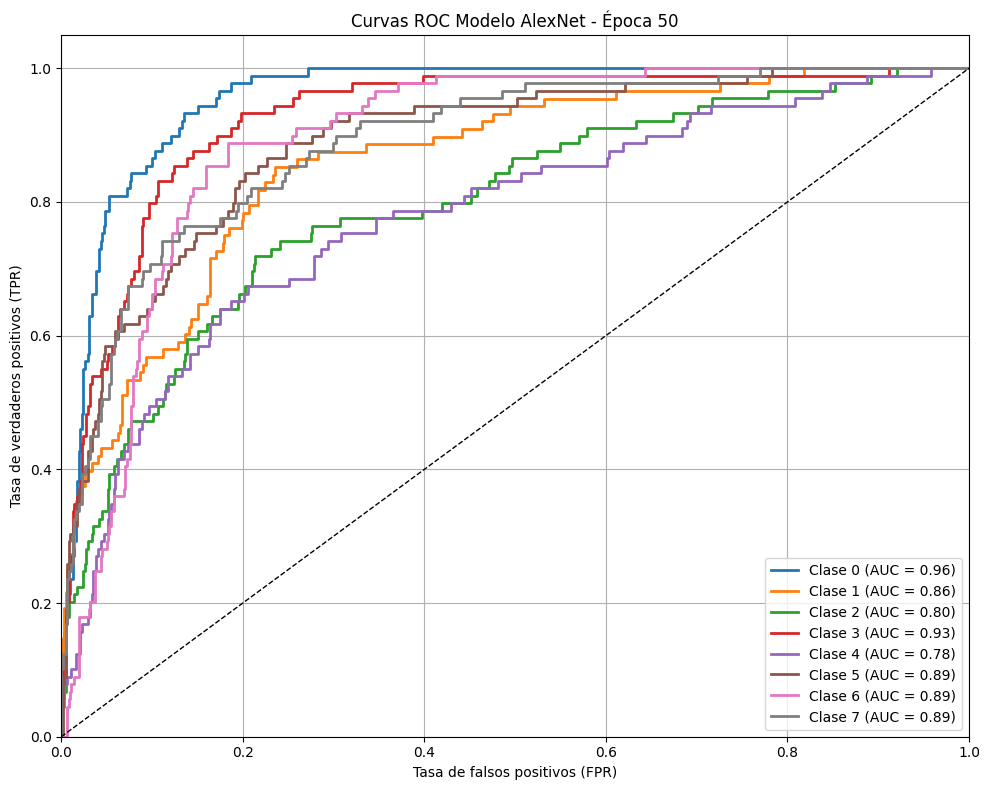

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_alexnet_3, classes=list(range(num_classes)))
y_score = np.array(prob_alexnet_3)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo AlexNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


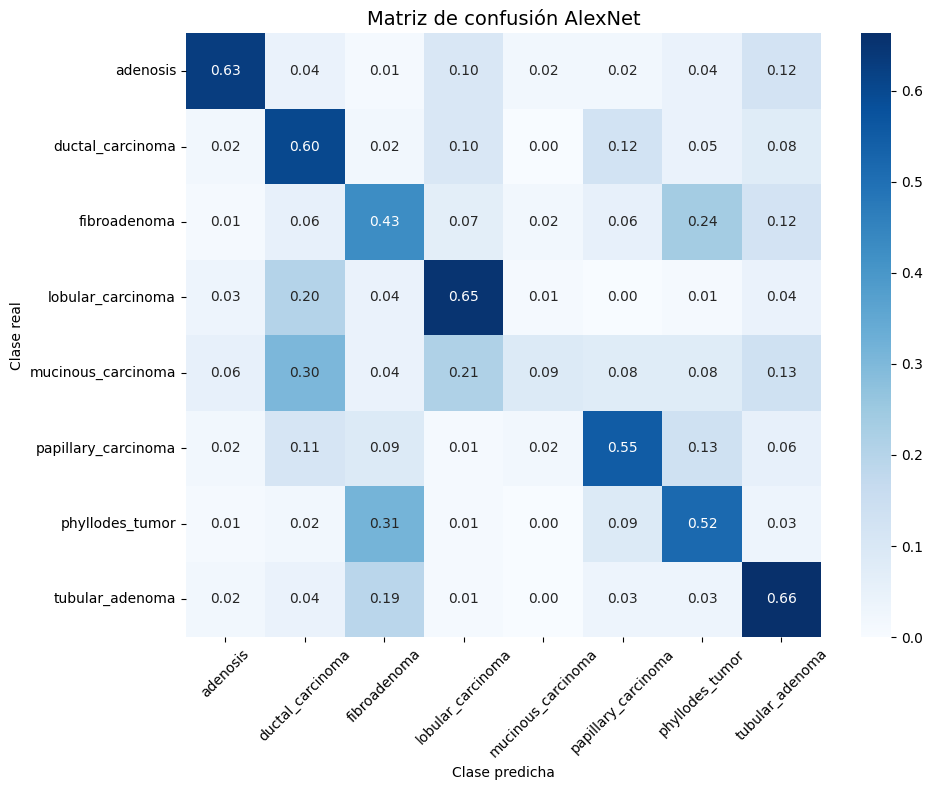

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_alexnet_3, pred_labels_alexnet_3)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión AlexNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [26]:
import os
from PIL import Image
import torch
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ==================================
# Modelo AlexNet preentrenado
# ==================================
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}\n")
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento dataloader + Evaluación
# ==============================================================================
epochs = 50

for epoch in range(epochs):
    # ============================== Entrenamiento =============================
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader_32, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_32)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader_32, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Pérdida para early stopping
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Guardar para métricas finales
            true_labels_list.extend(labels.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            # Accuracy temporal
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader_32)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=1.9524, Test Loss=1.7423, Test Acc=0.3671


Epoch 2: Train Loss=1.6018, Test Loss=1.4088, Test Acc=0.5274


Epoch 3: Train Loss=1.3173, Test Loss=1.1667, Test Acc=0.5809


Epoch 4: Train Loss=1.1124, Test Loss=1.0154, Test Acc=0.6315


Epoch 5: Train Loss=0.9514, Test Loss=0.9296, Test Acc=0.6526


Epoch 6: Train Loss=0.8255, Test Loss=0.8918, Test Acc=0.6751


Epoch 7: Train Loss=0.7184, Test Loss=0.8590, Test Acc=0.6765


Epoch 8: Train Loss=0.6417, Test Loss=0.8993, Test Acc=0.6793


Epoch 9: Train Loss=0.5668, Test Loss=0.8027, Test Acc=0.6878


Epoch 10: Train Loss=0.5116, Test Loss=0.7388, Test Acc=0.7243


Epoch 11: Train Loss=0.4290, Test Loss=0.7694, Test Acc=0.7103


Epoch 12: Train Loss=0.3904, Test Loss=0.7536, Test Acc=0.7145


Epoch 13: Train Loss=0.3511, Test Loss=0.7857, Test Acc=0.7173
🛑 Early stopping en epoch 13


<All keys matched successfully>

In [27]:
import os
from PIL import Image
import torch
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from random import shuffle

# ==================================
# Modelo AlexNet preentrenado
# ==================================
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# ==============================================================================
# Fine-tuning completo (descongelar capas convolucionales)
# ==============================================================================
# Las capas están descongeladas y se entrenarán.
for param in model.parameters():
    param.requires_grad = True

# Reemplazar la última capa del clasificador
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(f"Modelo modificado (última capa): {model.classifier}\n")  # Verificar la capa final
model = model.to(device)

# ==============================================================================
# Función de pérdida y optimizador
# ==============================================================================
criterion = nn.CrossEntropyLoss()
# Se optimizan todas las capas
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ==============================================================================
# Parámetros Early Stopping
# ==============================================================================
patience = 3
min_delta = 0.001
best_val_loss = float("inf")
patience_counter = 0
best_model_wts = None

# ==============================================================================
# Entrenamiento batch-loading + Evaluación
# ==============================================================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    # ============================= Entrenamiento ==============================
    model.train()
    running_loss = 0.0
    train_indices = list(range(len(train_image_paths)))
    shuffle(train_indices)

    for start_idx in tqdm(range(0, len(train_image_paths), batch_size), desc=f"Epoch {epoch+1} [Train]", leave=False):
        batch_indices = train_indices[start_idx:start_idx+batch_size]

        images, labels_batch = [], []
        for i in batch_indices:
            img = Image.open(train_image_paths[i]).convert("RGB")
            img = train_transform(img)
            images.append(img)
            labels_batch.append(train_labels[i])

        images_tensor = torch.stack(images).to(device)
        labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images_tensor)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_image_paths) / batch_size)

    # =============================== Evaluación ===============================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    true_labels_list, pred_labels_list, prob_list = [], [], []

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(test_image_paths), batch_size), desc=f"Epoch {epoch+1} [Test]", leave=False):
            batch_indices = list(range(start_idx, min(start_idx+batch_size, len(test_image_paths))))

            images, labels_batch = [], []
            for i in batch_indices:
                img = Image.open(test_image_paths[i]).convert("RGB")
                img = test_transform(img)
                images.append(img)
                labels_batch.append(test_labels[i])

            images_tensor = torch.stack(images).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            outputs = model(images_tensor)
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels_list.extend(labels_tensor.cpu().numpy())
            pred_labels_list.extend(preds.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())

            correct += (preds == labels_tensor).sum().item()
            total += labels_tensor.size(0)

    val_loss /= (len(test_image_paths) / batch_size)
    val_acc = correct / total
    print(f"\rEpoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f}")

    # Detectar overfitting (train_loss ≪ val_loss).
    # Detectar underfitting (train_loss y val_loss altos).
    # Ajustar learning rate, regularización, data augmentation, etc.

    # ============================= Early Stopping =============================
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch+1}")
            break

# =========================
# Restaurar mejores pesos
# =========================
model.load_state_dict(best_model_wts)


Modelo modificado (última capa): Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)



Epoch 1: Train Loss=1.5385, Test Loss=1.1558, Test Acc=0.5752


Epoch 2: Train Loss=1.1074, Test Loss=0.9194, Test Acc=0.6512


Epoch 3: Train Loss=0.8908, Test Loss=0.8171, Test Acc=0.6835


Epoch 4: Train Loss=0.7708, Test Loss=0.6858, Test Acc=0.7525


Epoch 5: Train Loss=0.6349, Test Loss=0.6143, Test Acc=0.7834


Epoch 6: Train Loss=0.5452, Test Loss=0.7647, Test Acc=0.7314


Epoch 7: Train Loss=0.4992, Test Loss=0.6160, Test Acc=0.7806


Epoch 8: Train Loss=0.4650, Test Loss=0.7410, Test Acc=0.7665
🛑 Early stopping en epoch 8


<All keys matched successfully>

In [28]:
# Prueba 4
true_labels_alexnet_4 = true_labels_list
pred_labels_alexnet_4 = pred_labels_list
prob_alexnet_4 = prob_list

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

acc_alexnet_4 = accuracy_score(true_labels_alexnet_4, pred_labels_alexnet_4)
error_rate_alexnet_4 = 1 - acc_alexnet_4
print(f"Accuracy total: {acc_alexnet_4:.4f}, Error rate: {error_rate_alexnet_4:.4f}\n")

print(classification_report(
    true_labels_alexnet_4,
    pred_labels_alexnet_4,
    labels=list(range(len(class_map))),
    target_names=class_map.keys(),
    zero_division=0
))

Accuracy total: 0.7665, Error rate: 0.2335

                     precision    recall  f1-score   support

           adenosis       0.83      0.96      0.89        89
   ductal_carcinoma       0.80      0.47      0.59        88
       fibroadenoma       0.59      0.76      0.67        89
  lobular_carcinoma       0.69      0.97      0.80        89
 mucinous_carcinoma       0.89      0.62      0.73        89
papillary_carcinoma       0.85      0.84      0.85        89
    phyllodes_tumor       0.76      0.72      0.74        89
    tubular_adenoma       0.86      0.80      0.83        89

           accuracy                           0.77       711
          macro avg       0.78      0.77      0.76       711
       weighted avg       0.78      0.77      0.76       711



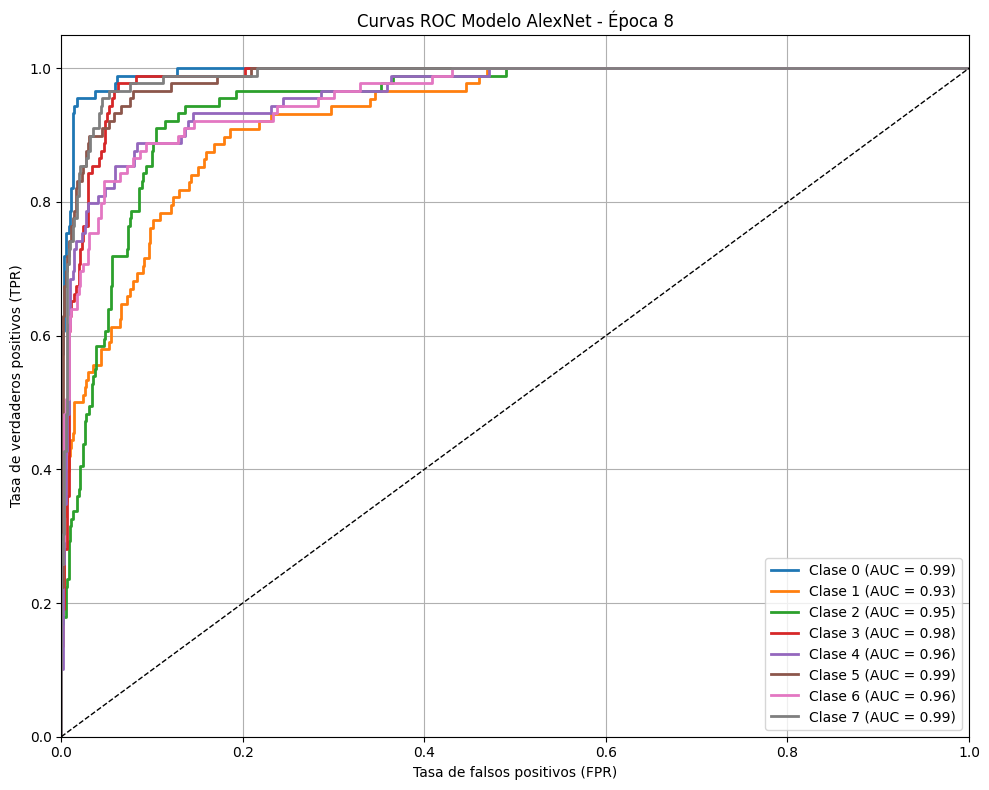

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza etiquetas verdaderas (one-hot)
y_true_bin = label_binarize(true_labels_alexnet_4, classes=list(range(num_classes)))
y_score = np.array(prob_alexnet_4)

# Curva ROC por clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title(f"Curvas ROC Modelo AlexNet - Época {epoch+1}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


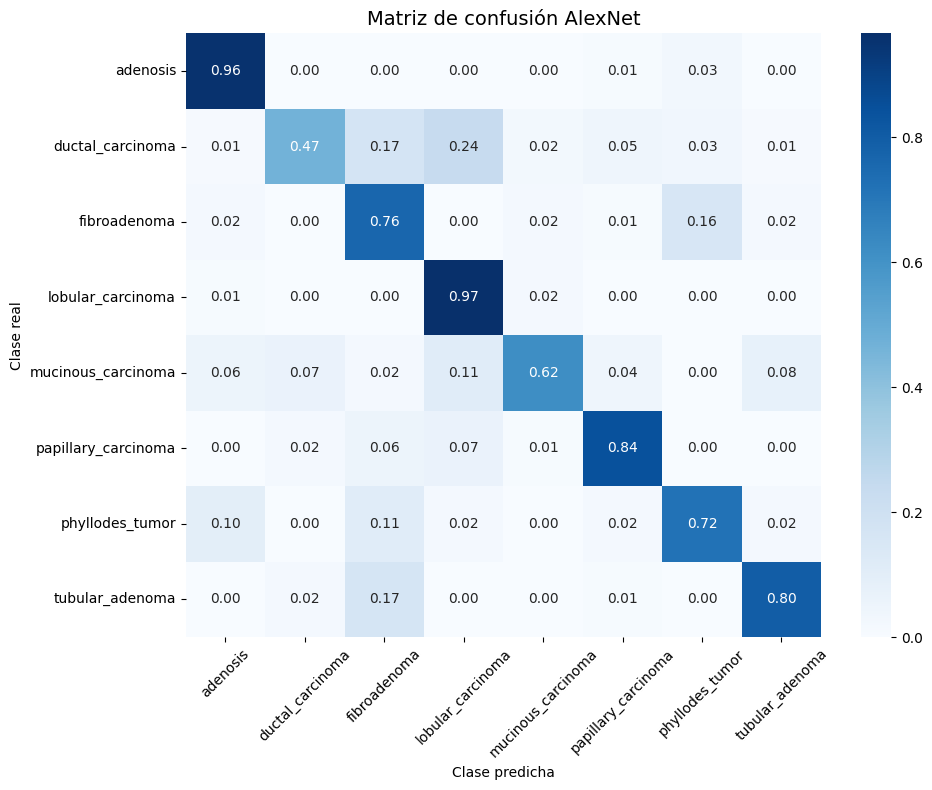

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_alexnet_4, pred_labels_alexnet_4)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)  # normalizar por fila

# Visualizar matriz normalizada
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión AlexNet", fontsize=14)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

